In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the necesary dependencies
import h5py
import numpy as np
import os
import random
from keras.layers import Input, Reshape, Conv2D, Dropout, Flatten, Dense, Activation, MaxPooling2D, AlphaDropout, BatchNormalization, add, concatenate
from keras.models import Model
from keras.optimizers import Adam
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import gc
import time

%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
# Defining the function to calculate higher-order statistics (cumulants) from the signal
def cumulants(x):
    X = np.array(x, dtype=np.complex64)
    X = X - np.mean(X) # To center the data by removing the mean
    M20 = np.mean(X**2)
    M21 = np.mean(np.abs(X)**2)
    M40 = np.mean(X**4)
    M41 = np.mean(X**3 * np.conj(X))
    M42 = np.mean((X**2) * (np.conj(X)**2))
    M60 = np.mean(X**6)
    C20 = M20
    C21 = M21
    C40 = M40 - 3*M21**2
    C41 = M41 - 3*M20*M21
    C42 = M42 - M21**2
    C60 = M60 - 15*M40*M20 + 30*M20**3
    return [C20, C21, C40, C41, C42, C60]


# Defining the function to extract various spectral features from the signal
def spectral_features(x):
    X = np.array(x, dtype=np.complex64)
    I = np.real(X) # In-phase component
    Q = np.imag(X) # Quadrature component
    a = np.abs(X)  # Amplitude
    p = np.angle(X)  # Phase
    beta = np.sum(Q**2) / np.sum(I**2)
    ma = np.mean(a)
    an = a / ma
    anc = an - 1
    RPA = np.max(a) / ma
    RPR = np.max(a**2) / np.sqrt(np.mean(a**2))
    gamma_max = np.max(np.abs(np.fft.fft(anc))**2) / len(anc)
    sigma_aa = np.std(anc)
    sigma_ap = np.std(p)
    sigma_dp = np.std(np.diff(p))
    skewness = np.mean(anc**3) / np.mean(anc**2)**1.5
    kurtosis = np.mean(anc**4) / np.mean(anc**2)**2
    return [beta, ma, RPA, RPR, gamma_max, sigma_aa, sigma_ap, sigma_dp, skewness, kurtosis]


# Defining the function to extract additional statistical features from the signal
def other_features(signal):
    energy = np.sum(np.abs(signal)**2, axis=0)
    entropy = -np.sum(signal * np.log2(np.abs(signal) + 1e-12), axis=0)
    geometric_power = np.exp(np.mean(np.log(np.abs(signal) + 1e-12), axis=0))
    p_norm = np.sum(np.abs(signal)**2, axis=0)**(1./2)
    return [energy, entropy, geometric_power, p_norm]


# Defining the function to extract and combine all the features from the signal data
def extract_features(X):
    features = []
    for x in X:
        cumulants_features = cumulants(x)
        spectral_features_values = spectral_features(x)
        other_features_values = other_features(x)

        # Flattenning the arrays to ensure they all have the same number of dimensions
        cumulants_features = np.ravel(cumulants_features)
        spectral_features_values = np.ravel(spectral_features_values)
        other_features_values = np.ravel(other_features_values)

        # Discarding the imaginary part of any complex numbers
        cumulants_features = cumulants_features.real
        spectral_features_values = spectral_features_values.real
        other_features_values = other_features_values.real

        feature_vector = np.concatenate([cumulants_features, spectral_features_values, other_features_values])
        features.append(feature_vector)

    return np.array(features)



In [ ]:
# Definig a function to load and combine data in batches to handle large datasets efficiently
def load_data_in_batches(base_path, num_parts, batch_size=3000):
    X_combined = np.empty((0, 1024, 2), dtype=np.float32)
    Y_combined = np.empty((0, 24), dtype=np.int32)
    Z_combined = np.empty((0, 1), dtype=np.float32)

    for i in range(num_parts):
        filename = os.path.join(base_path, f'part{i}.h5')
        print(f'Loading {filename}...')
        with h5py.File(filename, 'r') as f:
            sample_num = f['X'].shape[0]
            idx = np.random.choice(range(sample_num), size=batch_size, replace=False)
            idx.sort()
            X_combined = np.vstack((X_combined, f['X'][idx]))
            Y_combined = np.vstack((Y_combined, f['Y'][idx]))
            Z_combined = np.vstack((Z_combined, f['Z'][idx]))

        del f
        gc.collect()

    return X_combined, Y_combined, Z_combined

base_path = '/content/drive/My Drive/spectrum_sensing/split_parts/'
num_parts = 25
X_combined, Y_combined, Z_combined = load_data_in_batches(base_path, num_parts)

Loading /content/drive/My Drive/spectrum_sensing/split_parts/part0.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part1.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part2.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part3.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part4.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part5.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part6.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part7.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part8.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part9.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part10.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part11.h5...
Loading /content/drive/My Drive/spectrum_sensing/split_parts/part12.h5...
Loading /content/drive/My Drive/spectrum_sensing

In [ ]:
print(f'X_combined shape: {X_combined.shape}')
print(f'Y_combined shape: {Y_combined.shape}')
print(f'Z_combined shape: {Z_combined.shape}')

X_combined shape: (75000, 1024, 2)
Y_combined shape: (75000, 24)
Z_combined shape: (75000, 1)


In [ ]:
# Splitting the data into training and testing sets
n_examples = X_combined.shape[0]
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(n_examples), size=n_train, replace=False)
test_idx = list(set(range(n_examples)) - set(train_idx))

X_train = X_combined[train_idx]
Y_train = Y_combined[train_idx]
X_test = X_combined[test_idx]
Y_test = Y_combined[test_idx]

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (52500, 1024, 2)
Y_train: (52500, 24)
X_test: (22500, 1024, 2)
Y_test: (22500, 24)


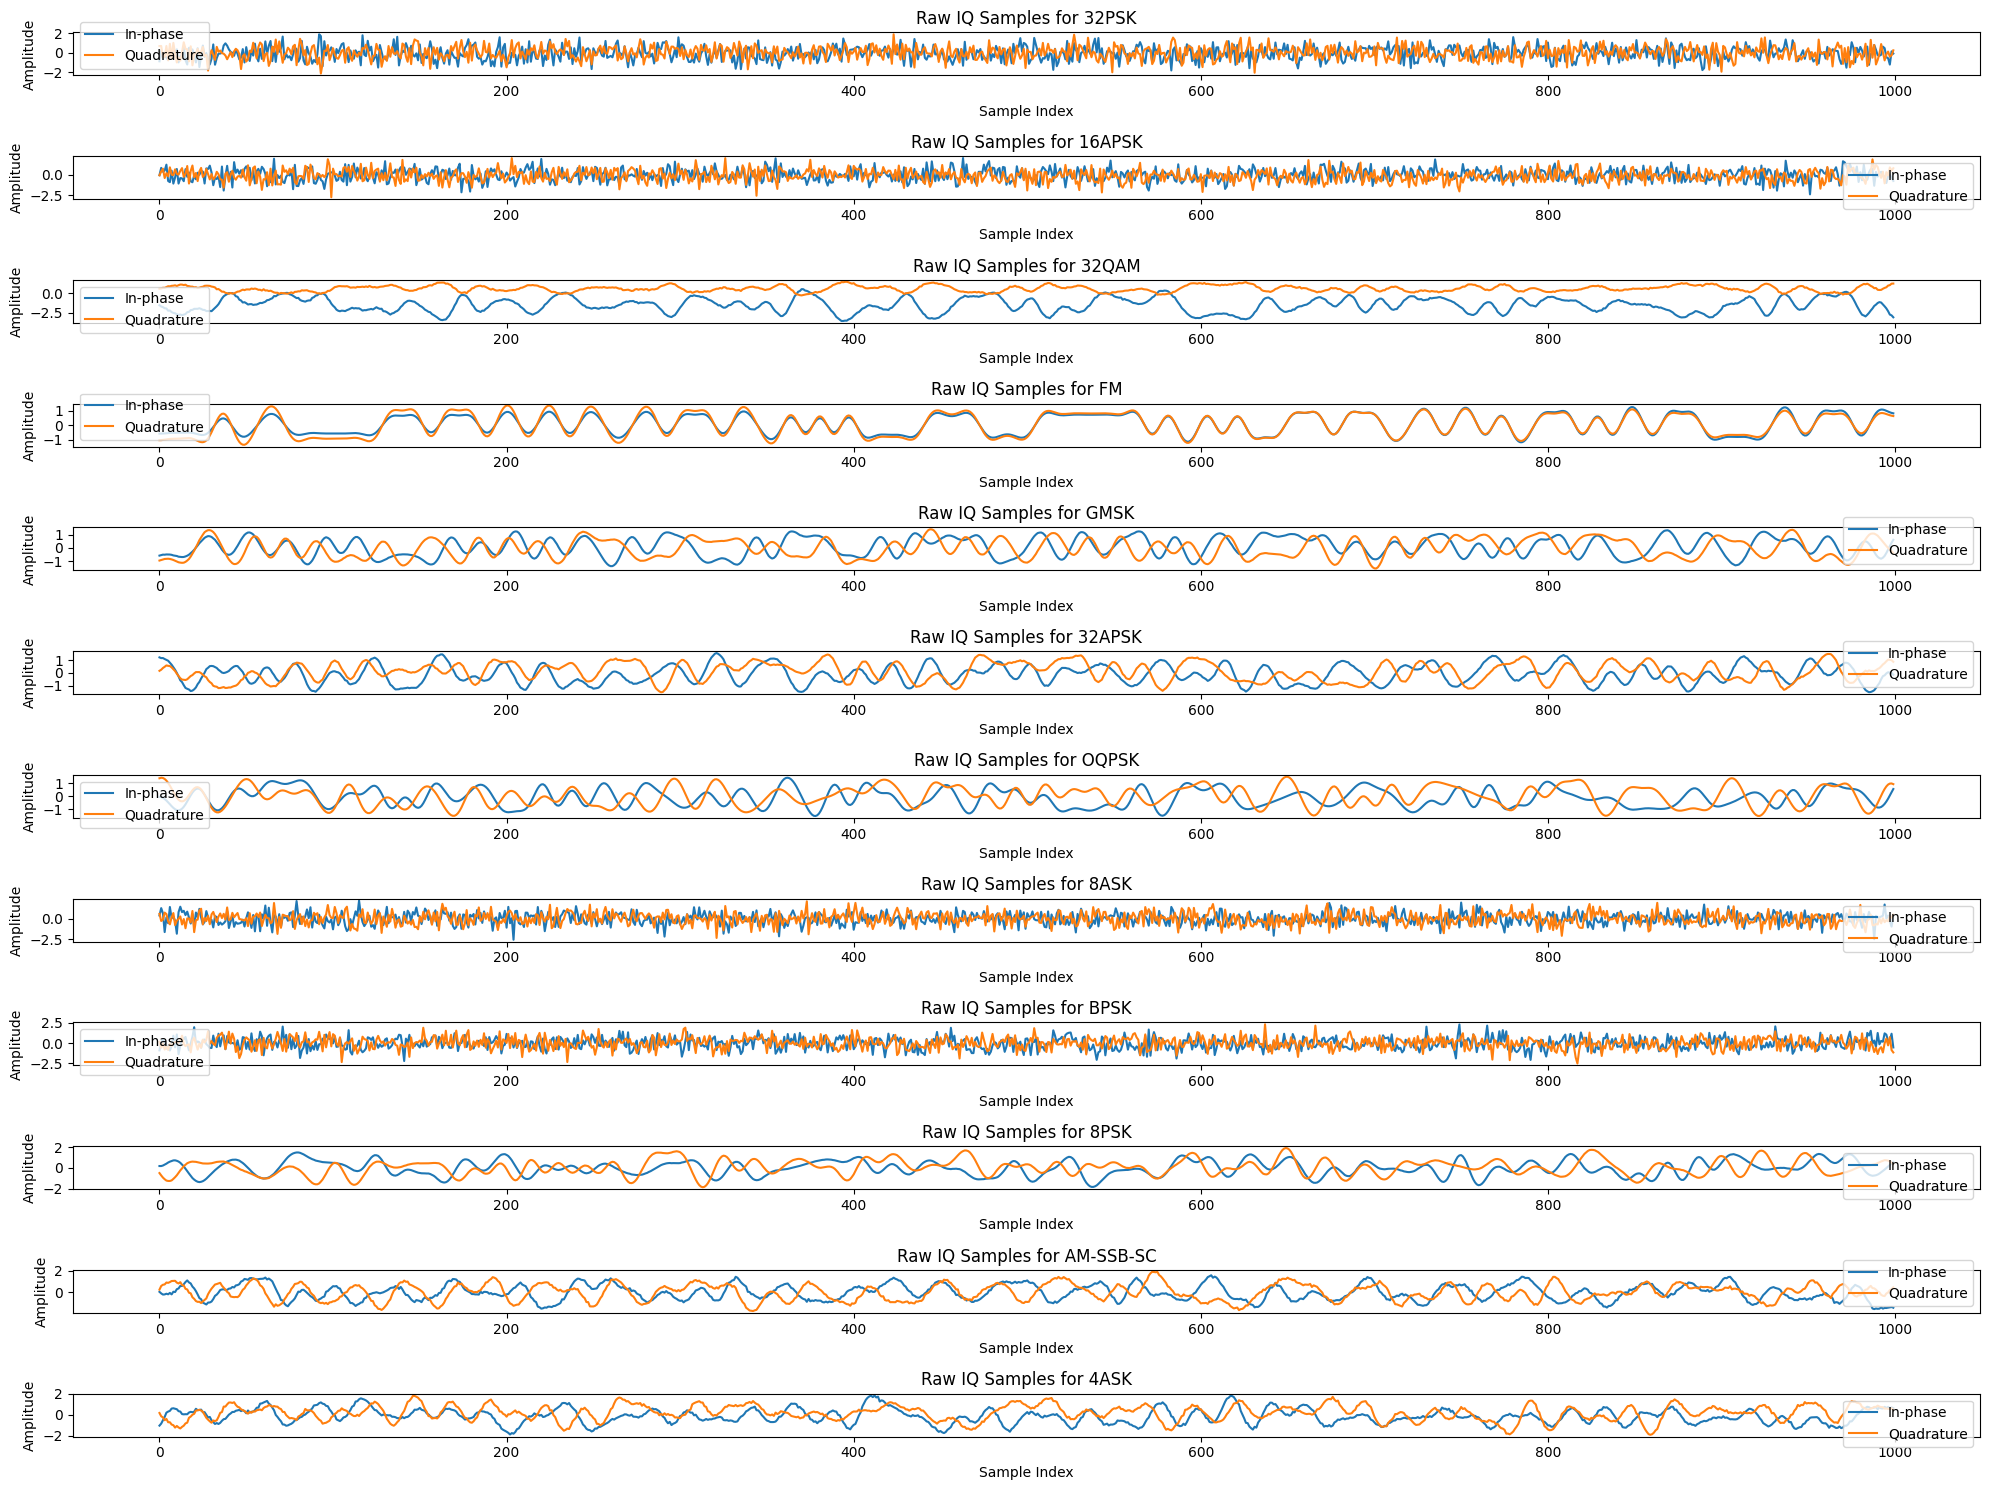

In [ ]:
# Function to plot raw IQ samples
def plot_iq_samples(X, Y, modulation_types, num_samples=1000):
    plt.figure(figsize=(20, 15))
    for i, mod_type in enumerate(modulation_types):
        # Find the first index where this modulation type occurs
        mod_idx = np.argmax(Y[:, i])
        plt.subplot(len(modulation_types), 1, i + 1)
        plt.plot(X[mod_idx, :num_samples, 0], label="In-phase")
        plt.plot(X[mod_idx, :num_samples, 1], label="Quadrature")
        plt.title(f"Raw IQ Samples for {mod_type}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
    plt.tight_layout()
    plt.show()

# List of modulation types
modulation_types = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK']

# Plot raw IQ samples for these modulation types
plot_iq_samples(X_train, Y_train, modulation_types)

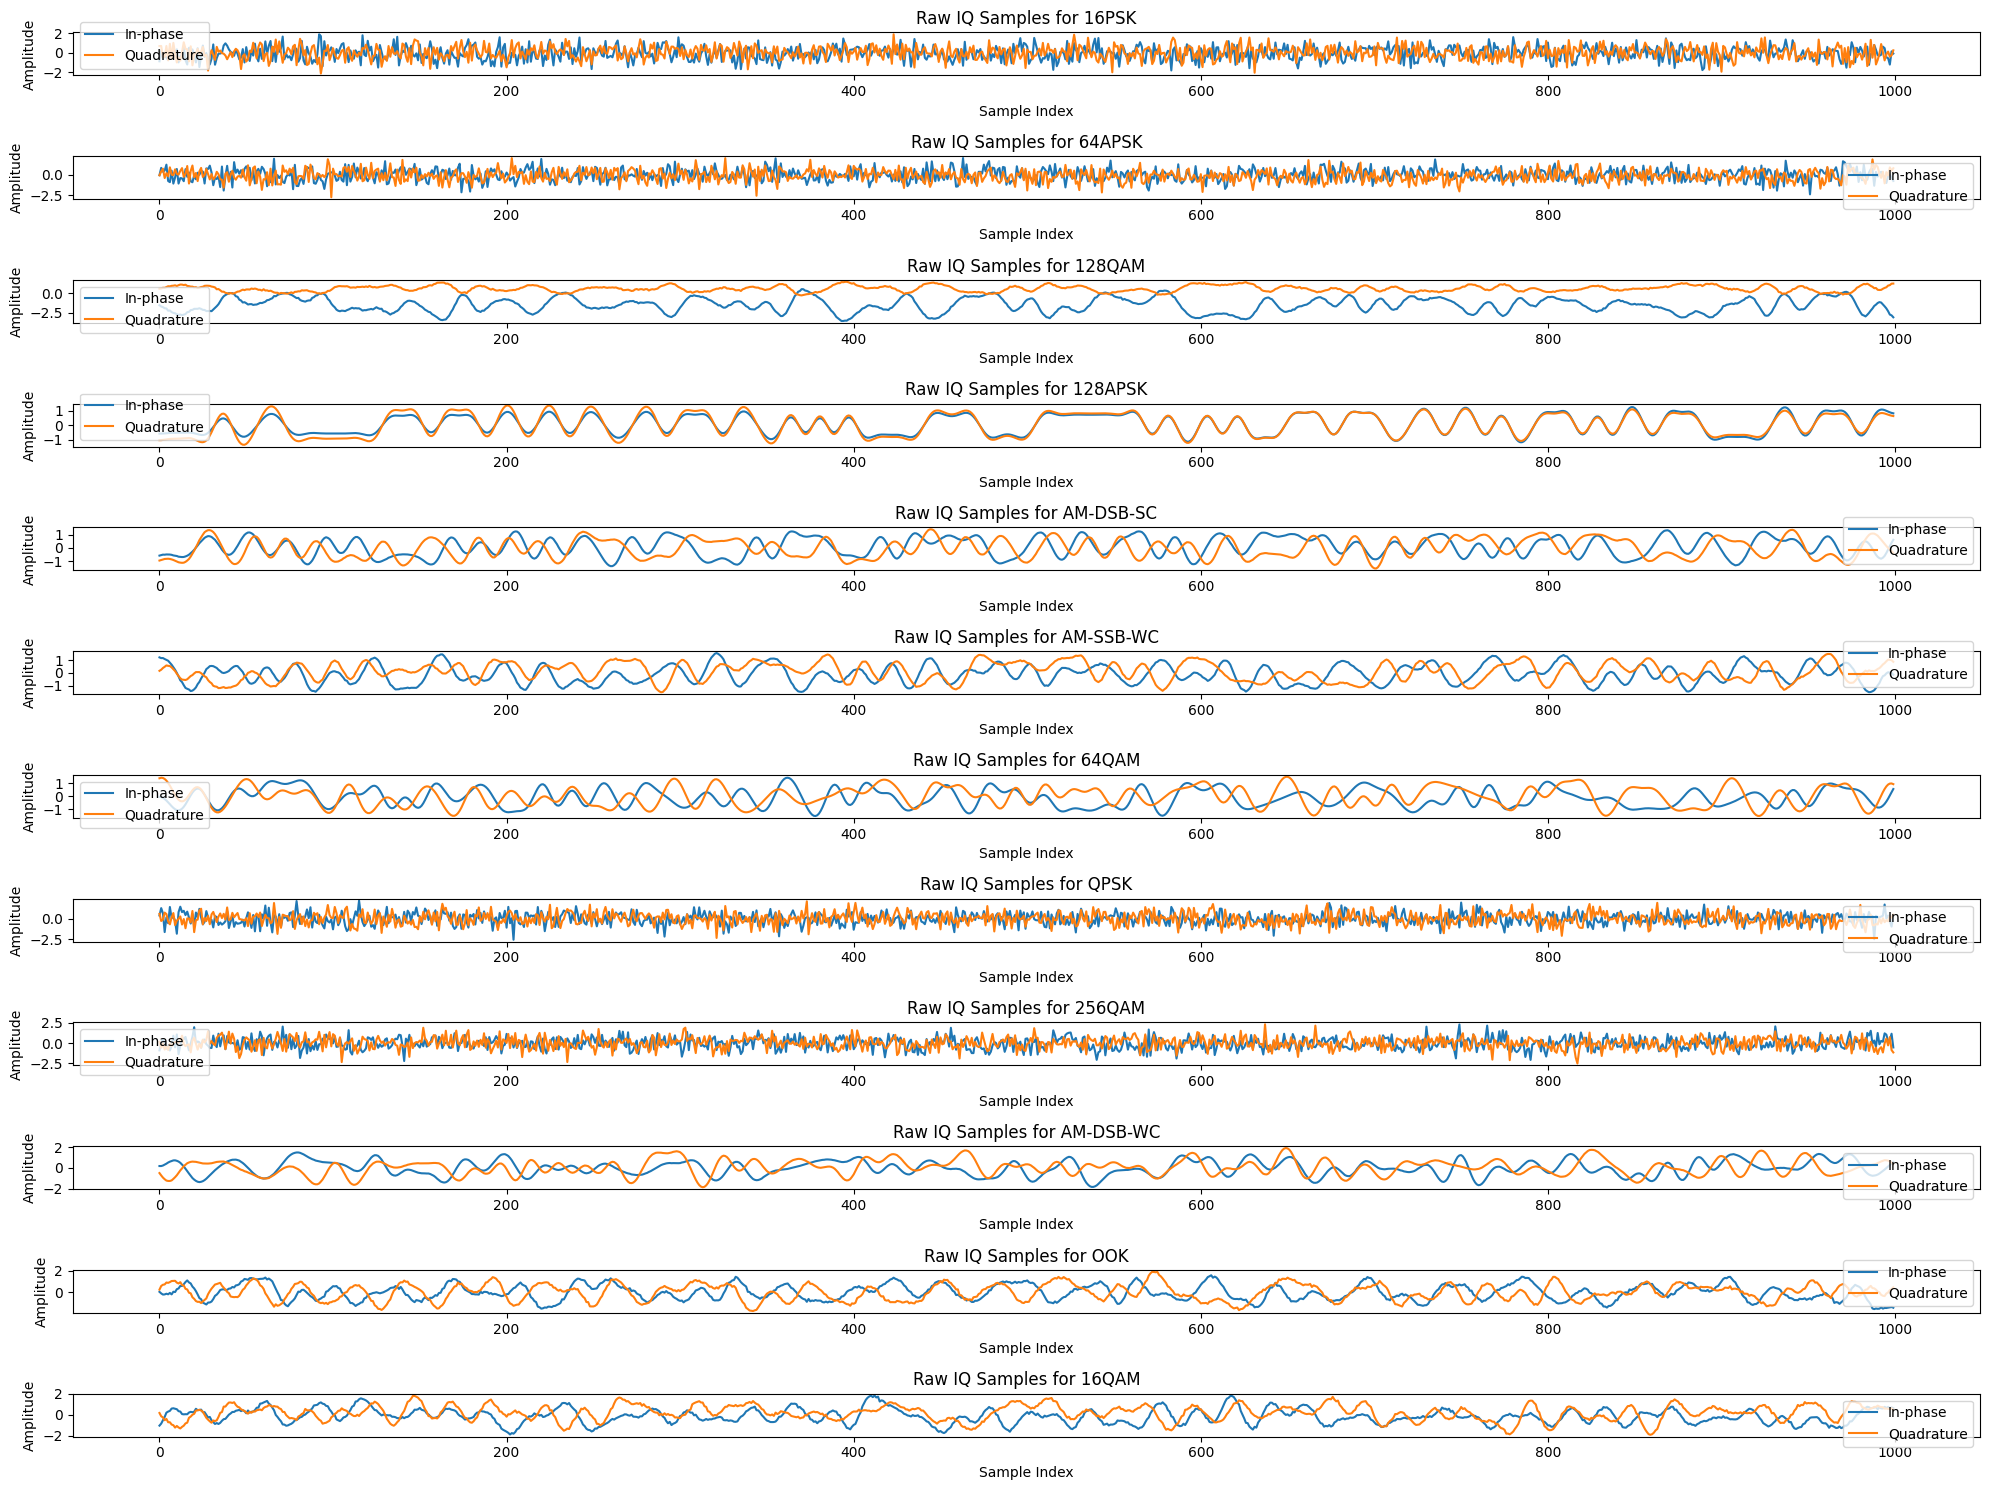

In [ ]:
# Function to plot raw IQ samples
def plot_iq_samples(X, Y, modulation_types, num_samples=1000):
    plt.figure(figsize=(20, 15))
    for i, mod_type in enumerate(modulation_types):
        # Find the first index where this modulation type occurs
        mod_idx = np.argmax(Y[:, i])
        plt.subplot(len(modulation_types), 1, i + 1)
        plt.plot(X[mod_idx, :num_samples, 0], label="In-phase")
        plt.plot(X[mod_idx, :num_samples, 1], label="Quadrature")
        plt.title(f"Raw IQ Samples for {mod_type}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
    plt.tight_layout()
    plt.show()

# List of modulation types
modulation_types = ['16PSK', '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC',
           'OOK', '16QAM']

# Plot raw IQ samples for these modulation types
plot_iq_samples(X_train, Y_train, modulation_types)

In [ ]:
# Defining the data augmentation function
def augment_data(X, Y):
    augmented_X, augmented_Y = [], []
    for signal, label in zip(X, Y):
        augmented_X.append(signal)
        augmented_Y.append(label)
        noise = np.random.normal(0, 0.1, signal.shape)
        augmented_X.append(signal + noise)
        augmented_Y.append(label)
        shift = np.random.randint(signal.shape[0])
        augmented_X.append(np.roll(signal, shift, axis=0))
        augmented_Y.append(label)
        scale = np.random.uniform(0.9, 1.1)
        augmented_X.append(signal * scale)
        augmented_Y.append(label)
    return np.array(augmented_X), np.array(augmented_Y)

X_train, Y_train = augment_data(X_train, Y_train)

In [ ]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

X_train: (210000, 1024, 2)
Y_train: (210000, 24)


In [ ]:
#The extracted features
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

In [ ]:
print("X_train_features:", X_train_features.shape)
print("X_test_features:", X_test_features.shape)

X_train_features: (210000, 24)
X_test_features: (22500, 24)


In [ ]:
print(X_train_features[0])
print(X_test_features[0])

[ 5.03800750e-01  5.03800750e-01 -2.86990885e-01 -2.86990885e-01
  2.20639505e-01  8.39734560e-01  0.00000000e+00  6.19412422e-01
  2.90924311e+00  4.57498264e+00  5.40553674e-03  5.59561908e-01
  1.57055378e+00  2.20298433e+00  1.66845257e-01  2.31936882e+00
  5.19216853e+02  5.12571741e+02 -1.25039235e+00 -1.62929157e+01
  4.75448785e-01  4.68957963e-01  2.27863304e+01  2.26400473e+01]
[ 5.04206538e-01  5.04206538e-01  3.93653740e-02  3.93653740e-02
  5.47813840e-01  2.51002383e-01  0.00000000e+00  5.69366038e-01
  5.41613674e+00  1.33918180e+01  2.83056984e-02  7.45300770e-01
  1.57076943e+00  2.23438621e+00  1.11849485e+00  4.71559696e+00
  5.38784607e+02  4.93918579e+02 -1.23539495e+01 -2.66958594e+00
  3.93805683e-01  3.85076225e-01  2.32117348e+01  2.22242794e+01]


In [ ]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

In [ ]:
print(X_train_features[0])
print(X_test_features[0])

[-0.10574096 -0.10574096  0.02179106  0.02179106 -0.10567283 -0.00713513
  0.         -0.17257666 -0.70926816 -0.77303419 -0.98401131 -1.05271538
  0.23528127  0.29574363 -1.14687412 -0.78639993 -0.09639158 -0.11176632
  0.0039551  -0.00533448 -0.12346179 -0.12568149 -0.1784153  -0.18190621]
[-1.05698269e-01 -1.05698270e-01  2.18298360e-02  2.18298359e-02
 -8.02267060e-02 -7.13513589e-03  0.00000000e+00 -2.16235837e-01
  1.87961292e+00  1.82135355e+00  2.10066057e+00  3.39844732e-01
  2.36172222e-01  3.47120865e-01  1.16521002e+00  2.11058562e+00
 -9.55204026e-02 -1.12812028e-01  1.78879204e-03 -2.48479242e-03
 -1.84095150e-01 -1.90909849e-01 -1.68295332e-01 -1.92268370e-01]


In [ ]:
# Defining a residual stack for the ResNet architecture
def residual_stack(X, Filters, Seq, max_pool):
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same', activation="relu", name=Seq+"_conv2", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = add([X, X_shortcut])
    X = Activation("relu")(X)
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same', activation="relu", name=Seq+"_conv4", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform', data_format="channels_first")(X)
    X = add([X, X_shortcut])
    X = Activation("relu")(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

#Defining the hybrid model combining CNN and ResNet with extracted features
def create_residual_model(input_shape, feature_shape, num_classes):
    X_input = Input(input_shape) # Raw IQ data input
    feature_input = Input(shape=feature_shape) # Extracted feature input

    X = Reshape([1, 1024, 2], input_shape=input_shape)(X_input)
    X = residual_stack(X, 32, "ReStk1", False)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    X = residual_stack(X, 32, "ReStk2", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk3", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk4", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk5", True)
    X = BatchNormalization()(X)
    X = residual_stack(X, 32, "ReStk6", True)
    X = BatchNormalization()(X)
    X = Flatten()(X)# Concatenate CNN output with extracted features
    X = concatenate([X, feature_input])

    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = AlphaDropout(0.3)(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = AlphaDropout(0.3)(X)
    X = Dense(num_classes, kernel_initializer='he_normal', name="dense3")(X)
    X = Activation('softmax')(X)
    model = Model(inputs=[X_input, feature_input], outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
input_shape = (1024, 2)
feature_shape = (X_train_features.shape[1],)
num_classes = Y_train.shape[1]
model = create_residual_model(input_shape, feature_shape, num_classes)
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.1**(epoch // 10))
]

start_time = time.time()
history = model.fit([X_train, X_train_features], Y_train, batch_size=128, epochs=100, validation_data=([X_test, X_test_features], Y_test), callbacks=callbacks)
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch 1/100
1641/1641 [==============================] - 135s 73ms/step - loss: 2.1876 - accuracy: 0.2580 - val_loss: 1.9490 - val_accuracy: 0.3215 - lr: 0.0010
Epoch 2/100
1641/1641 [==============================] - 116s 71ms/step - loss: 1.8373 - accuracy: 0.3508 - val_loss: 1.9060 - val_accuracy: 0.3537 - lr: 0.0010
Epoch 3/100
1641/1641 [==============================] - 116s 71ms/step - loss: 1.7299 - accuracy: 0.3856 - val_loss: 1.7975 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 4/100
1641/1641 [==============================] - 116s 71ms/step - loss: 1.6673 - accuracy: 0.4078 - val_loss: 1.8232 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 5/100
1641/1641 [==============================] - 116s 71ms/step - loss: 1.6173 - accuracy: 0.4311 - val_loss: 1.7256 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 6/100
1641/1641 [==============================] - 116s 71ms/step - loss: 1.5755 - accuracy: 0.4527 - val_loss: 1.5826 - val_accuracy: 0.4680 - lr: 0.0010
Epoch 7/100
1641/1641 [===========

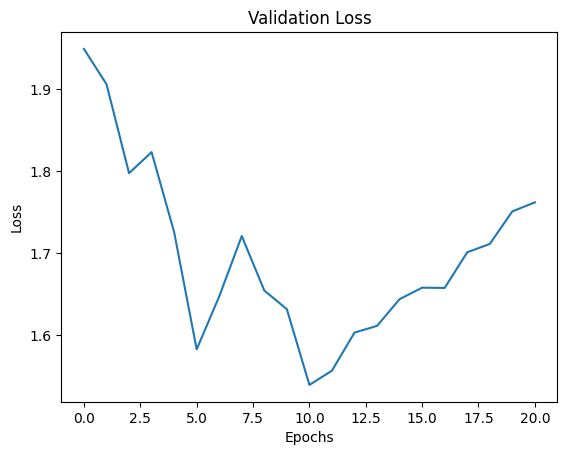

In [ ]:
# Plotting the validation loss over epoch
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
#PLotting the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Define class labels
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK',
           '16PSK', '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC',
           'OOK', '16QAM']

22/22 [==============================] - 3s 128ms/step
32PSK 0.7435344827586207
16APSK 0.648619957537155
32QAM 0.6062231759656652
FM 0.6567164179104478
GMSK 0.6102403343782654
32APSK 0.5506198347107438
OQPSK 0.25689084895259096
8ASK 0.48294243070362475
BPSK 0.6725571725571725
8PSK 0.5832492431886983
AM-SSB-SC 0.4803229061553986
4ASK 0.34496510468594216
16PSK 0.5136554621848739
64APSK 0.421875
128QAM 0.0670995670995671
128APSK 0.3062692702980473
AM-DSB-SC 0.329938900203666
AM-SSB-WC 0.16497975708502025
64QAM 0.7017726798748697
QPSK 0.6149732620320856
256QAM 0.5447070914696814
AM-DSB-WC 0.7923946557040082
OOK 0.6779835390946503
16QAM 0.5619469026548672
30/30 [==============================] - 2s 27ms/step
Overall Accuracy -20.0:  0.046858359957401494
29/29 [==============================] - 1s 28ms/step
Overall Accuracy -18.0:  0.03172866520787746
29/29 [==============================] - 1s 28ms/step
Overall Accuracy -16.0:  0.044906900328587074
27/27 [==============================] - 0

<ipython-input-15-dd37d8b7b599>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


28/28 [==============================] - 1s 28ms/step
Overall Accuracy 0.0:  0.47368421052631576
30/30 [==============================] - 0s 5ms/step
Overall Accuracy 2.0:  0.549520766773163
27/27 [==============================] - 1s 33ms/step
Overall Accuracy 4.0:  0.6518171160609613
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 6.0:  0.7364705882352941


<ipython-input-18-8cdc2fd203f1>:32: RuntimeWarning: invalid value encountered in divide
  confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])


26/26 [==============================] - 0s 5ms/step
Overall Accuracy 8.0:  0.7584134615384616
27/27 [==============================] - 1s 29ms/step
Overall Accuracy 10.0:  0.7971188475390156
26/26 [==============================] - 0s 5ms/step
Overall Accuracy 12.0:  0.8261933904528764
28/28 [==============================] - 1s 31ms/step
Overall Accuracy 14.0:  0.8270762229806599
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 16.0:  0.8300117233294255
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 18.0:  0.8127250900360145
28/28 [==============================] - 0s 5ms/step
Overall Accuracy 20.0:  0.8339021615472128
27/27 [==============================] - 1s 28ms/step
Overall Accuracy 22.0:  0.8510131108462455
26/26 [==============================] - 1s 32ms/step
Overall Accuracy 24.0:  0.829683698296837
27/27 [==============================] - 0s 5ms/step
Overall Accuracy 26.0:  0.8329466357308585
26/26 [==============================]

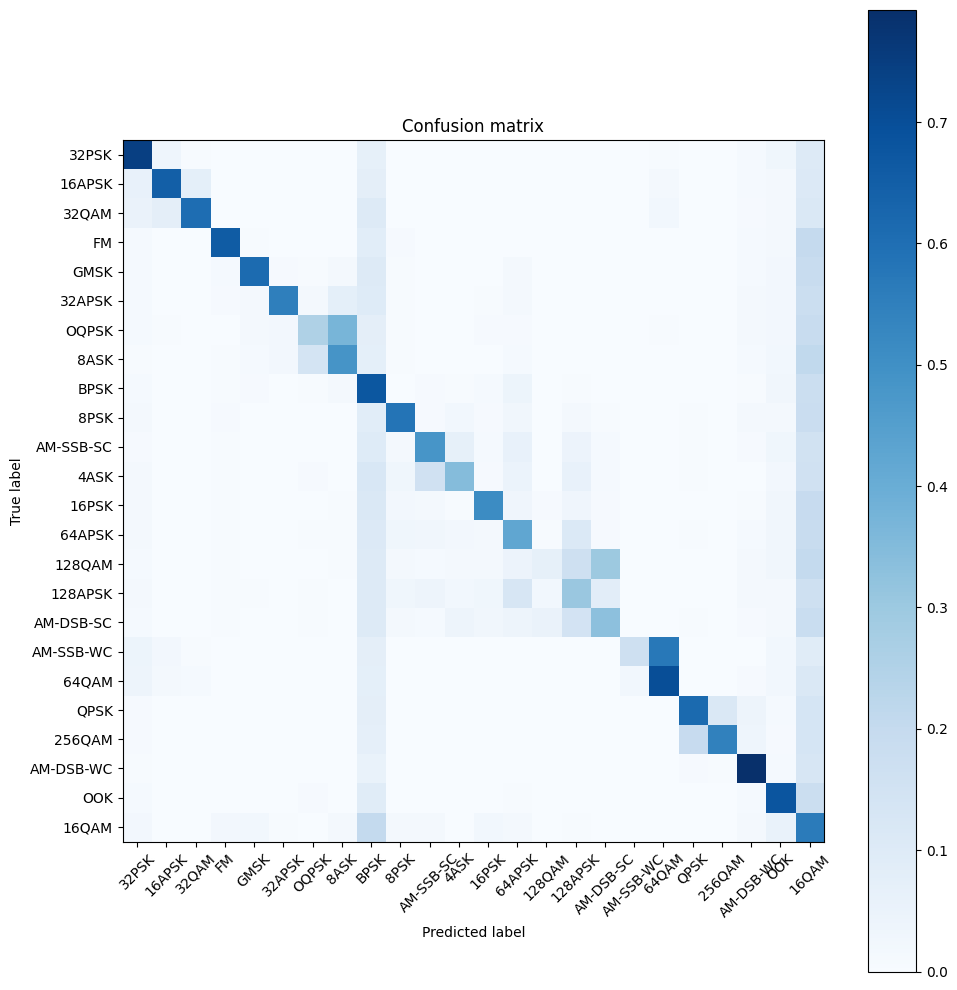

<Figure size 640x480 with 0 Axes>

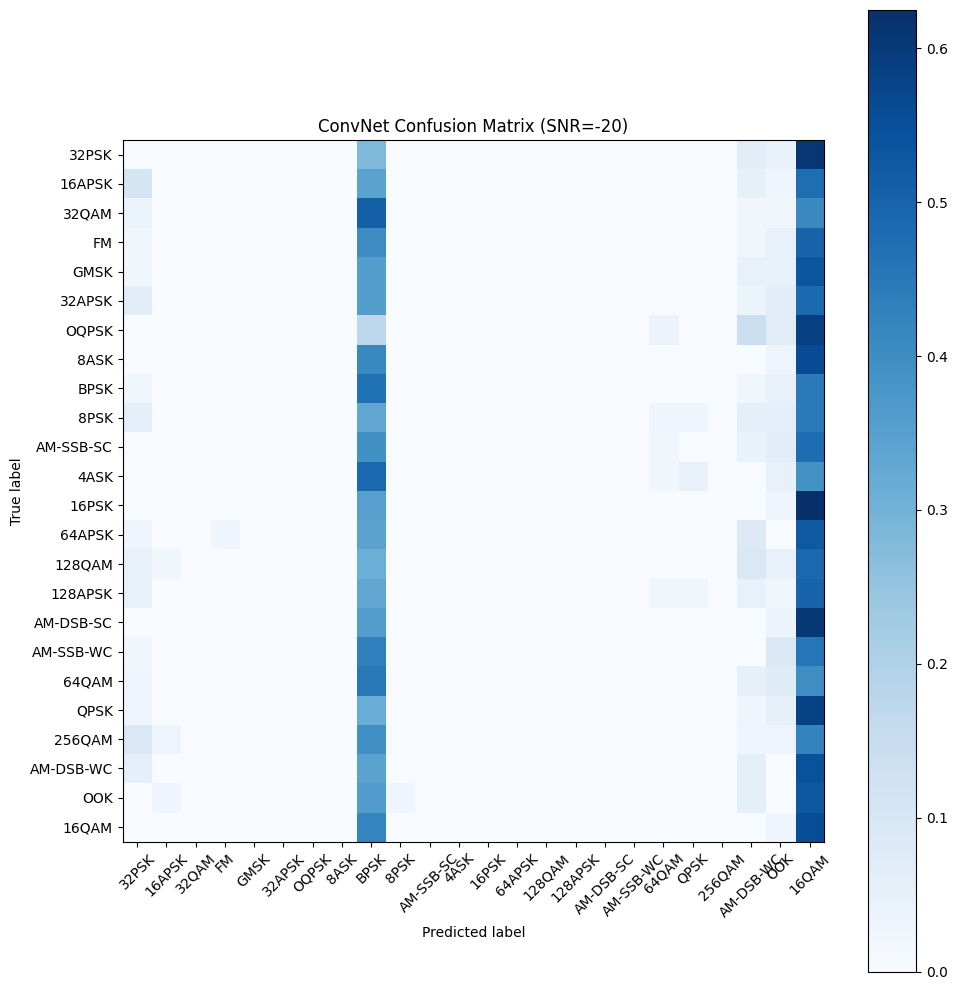

<Figure size 640x480 with 0 Axes>

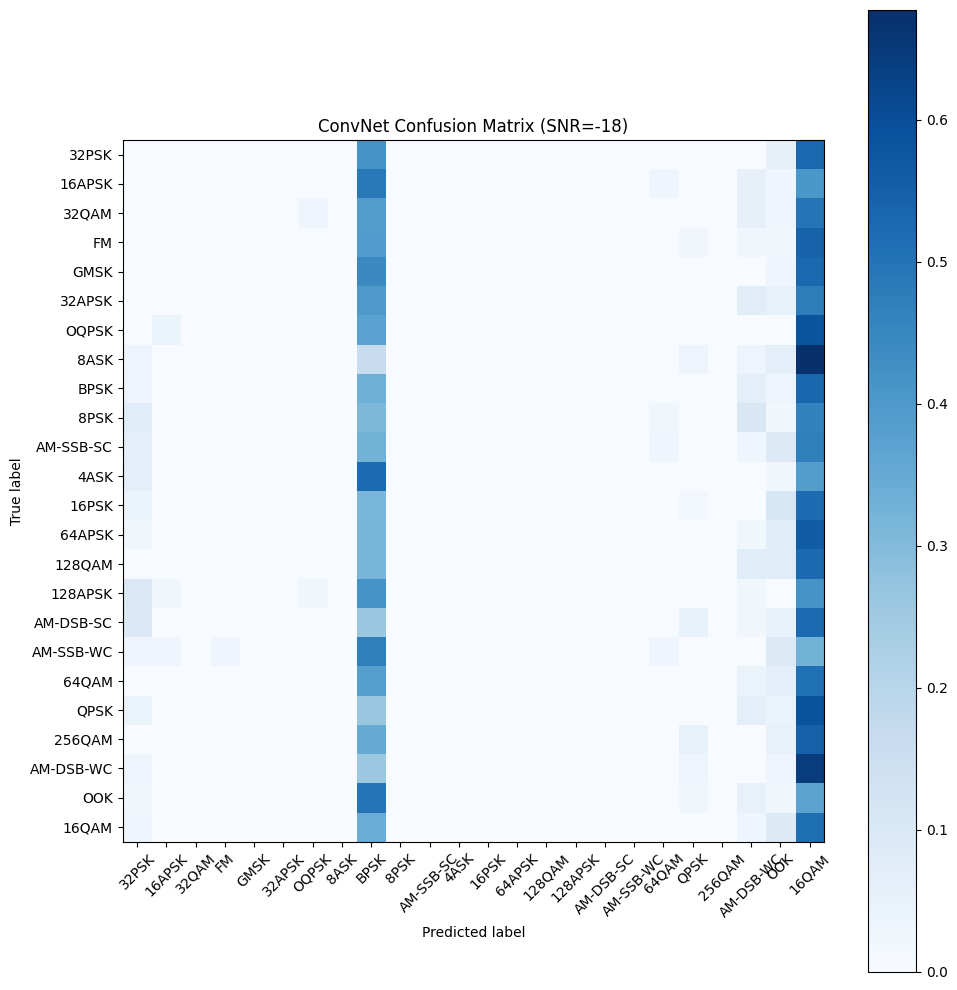

<Figure size 640x480 with 0 Axes>

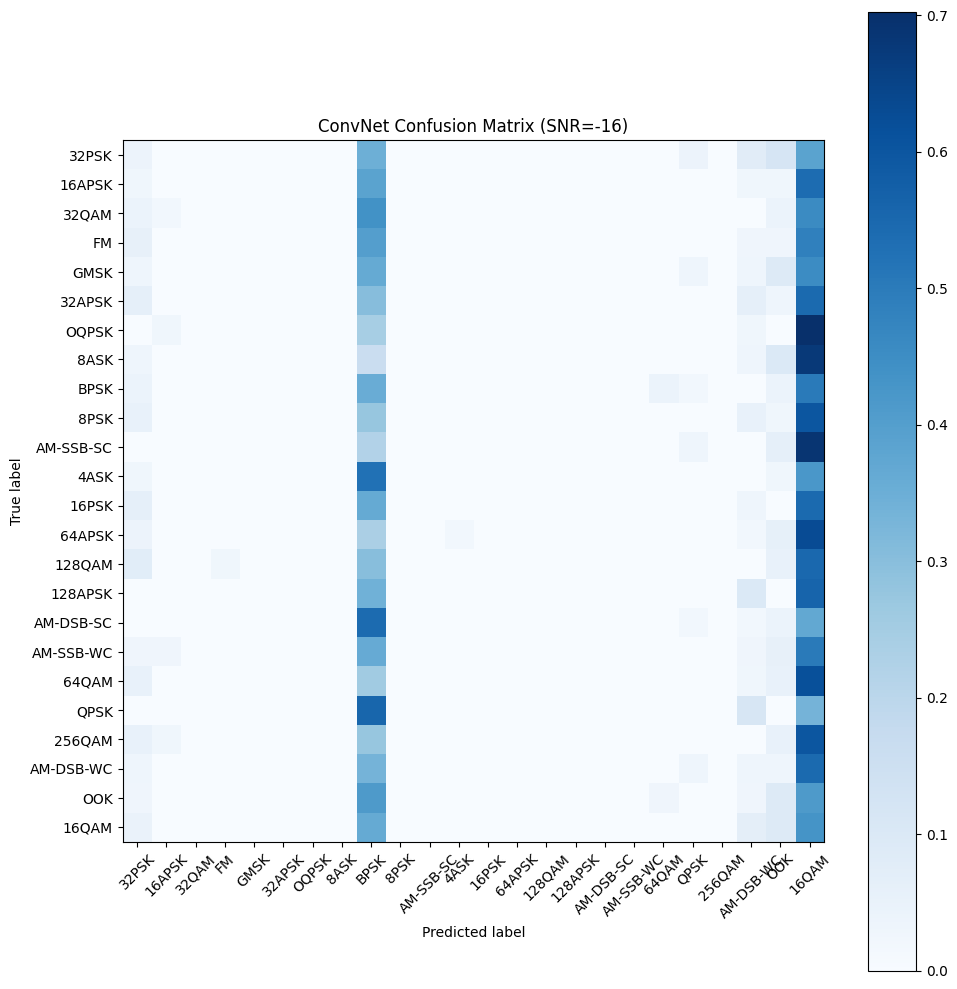

<Figure size 640x480 with 0 Axes>

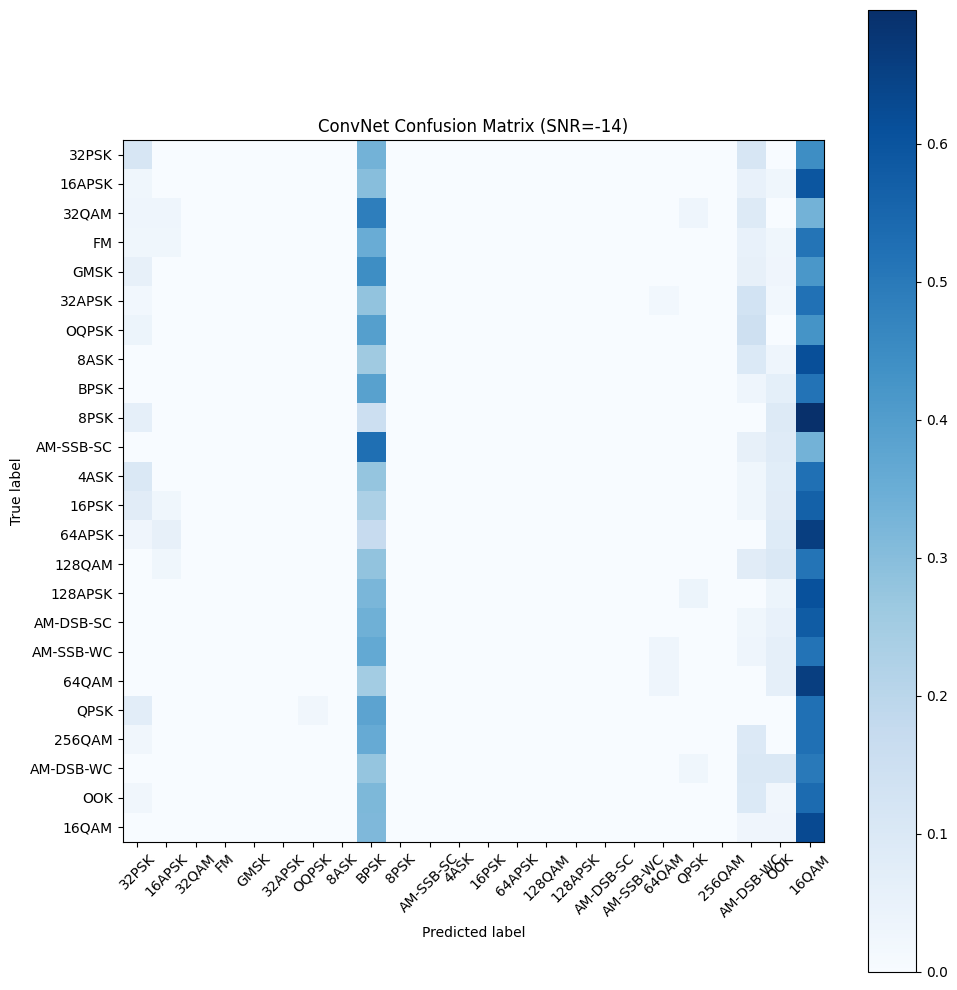

<Figure size 640x480 with 0 Axes>

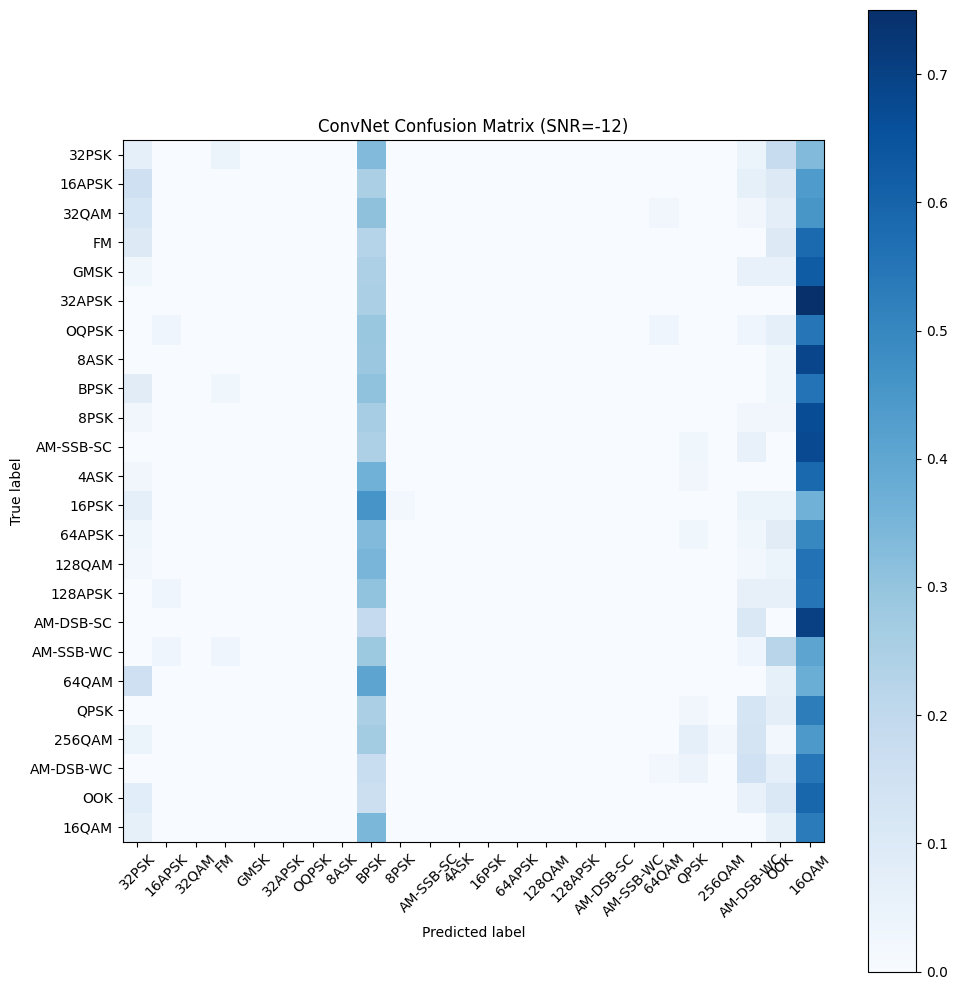

<Figure size 640x480 with 0 Axes>

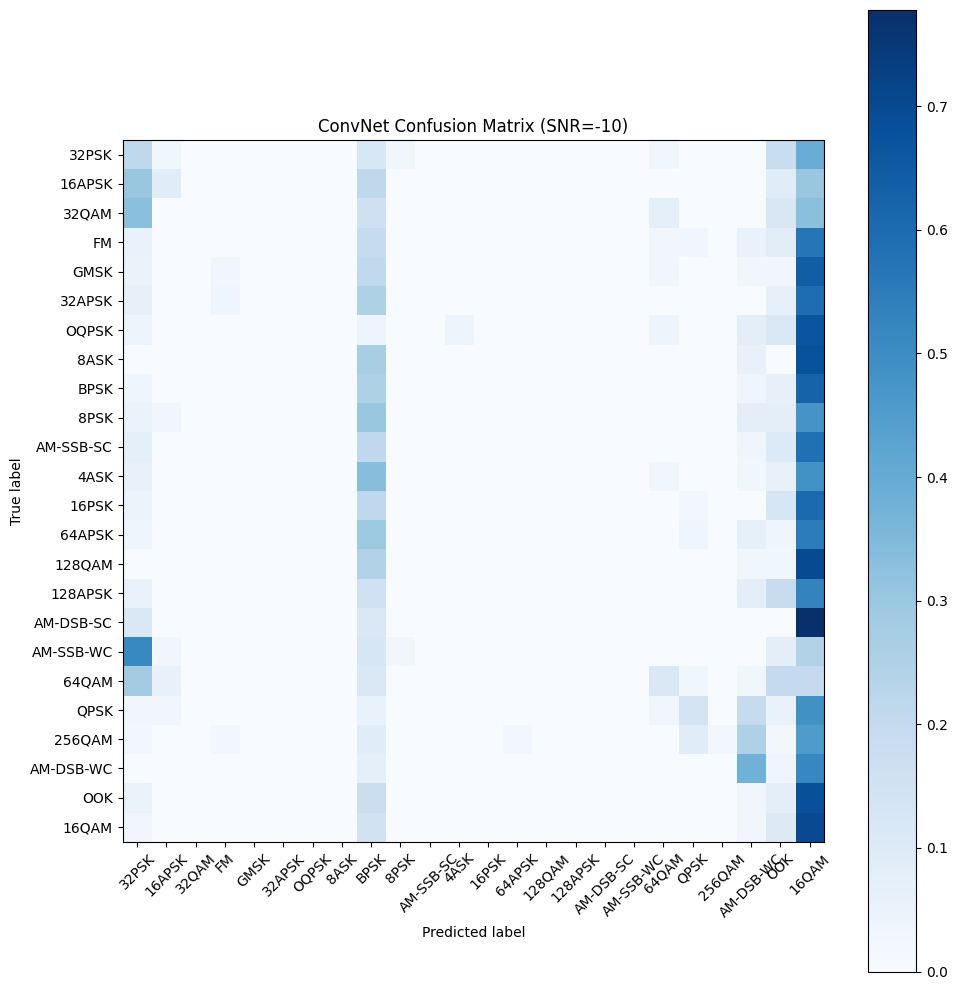

<Figure size 640x480 with 0 Axes>

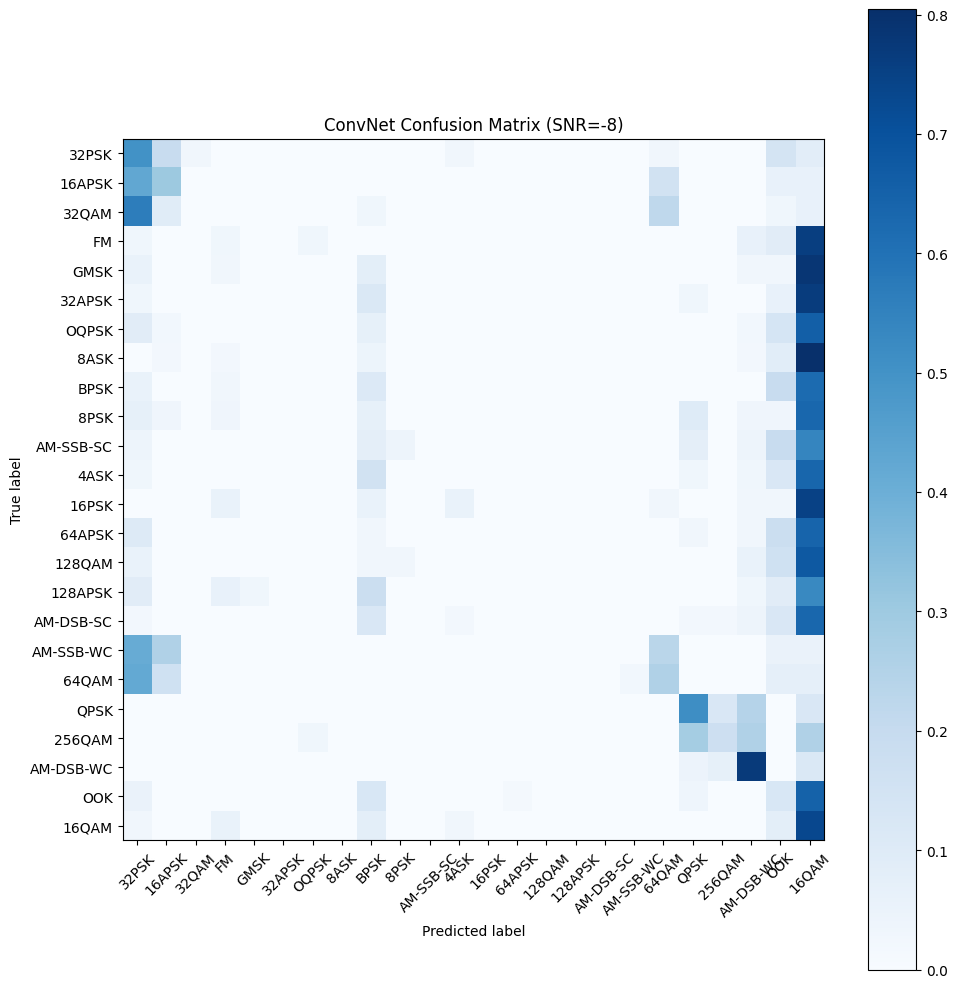

<Figure size 640x480 with 0 Axes>

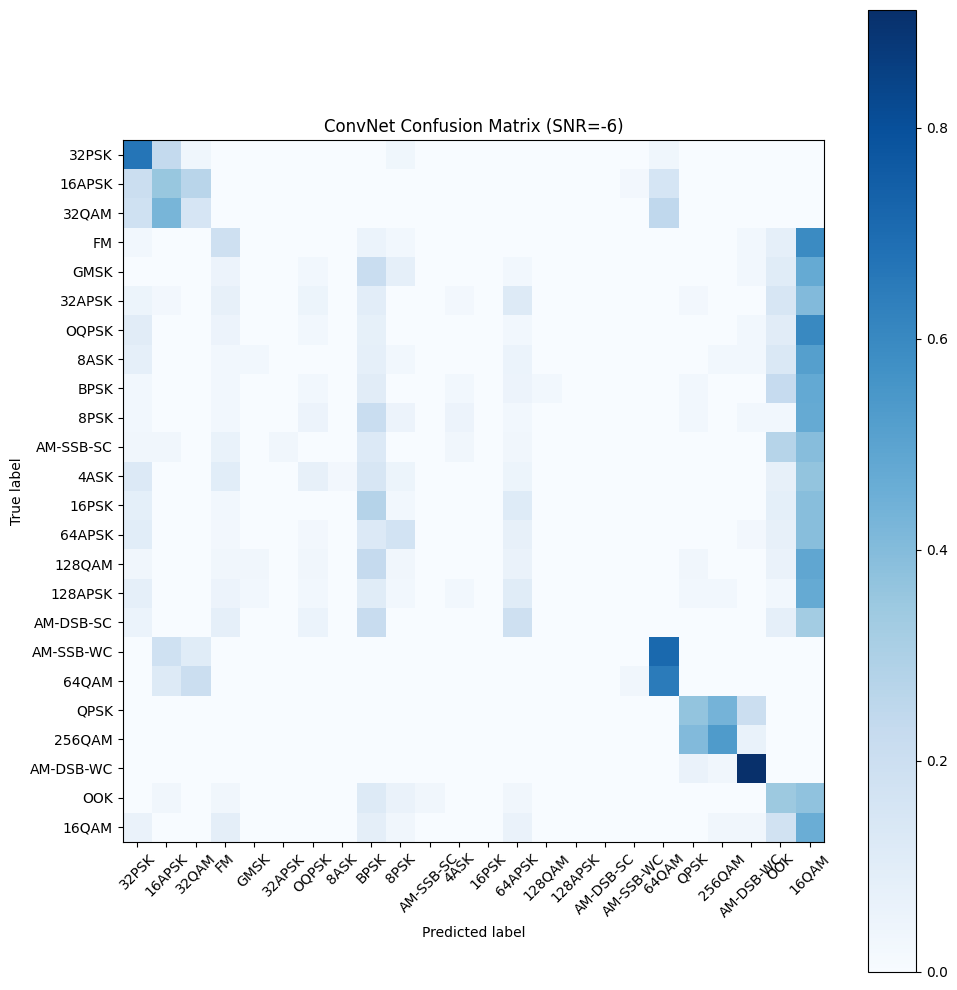

<Figure size 640x480 with 0 Axes>

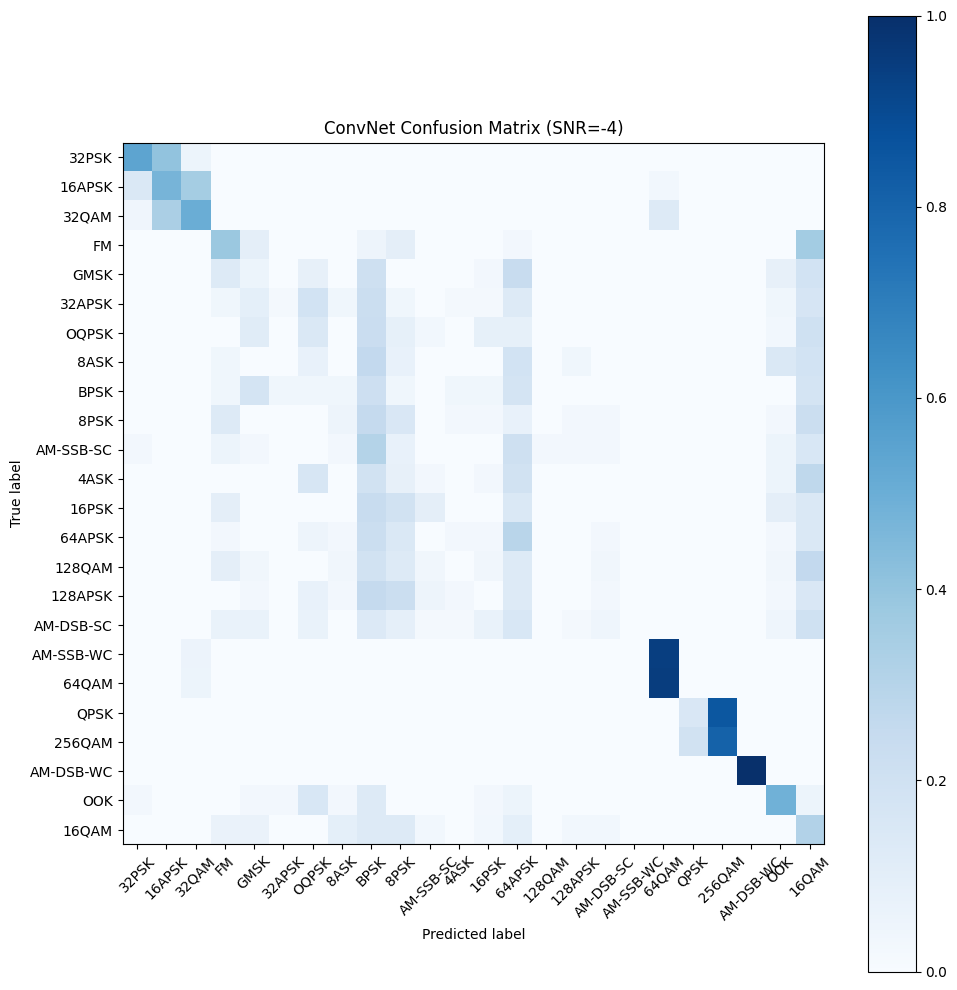

<Figure size 640x480 with 0 Axes>

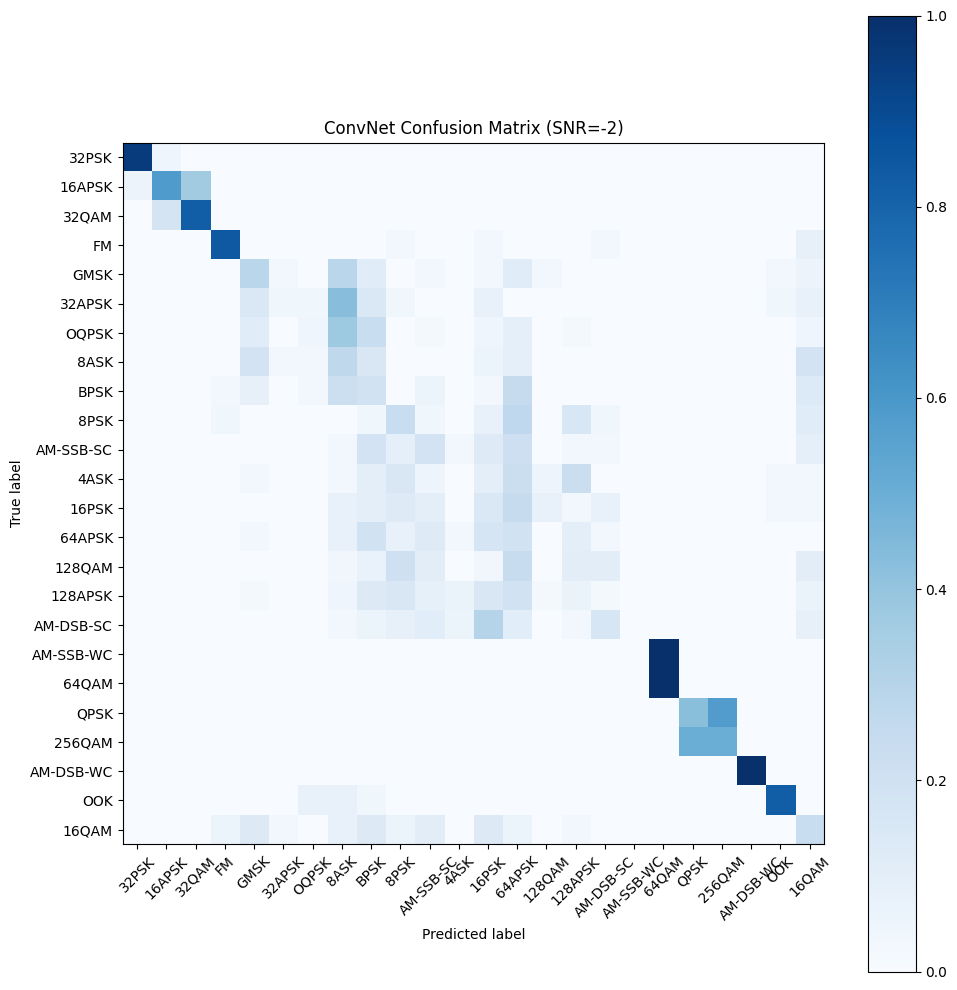

<Figure size 640x480 with 0 Axes>

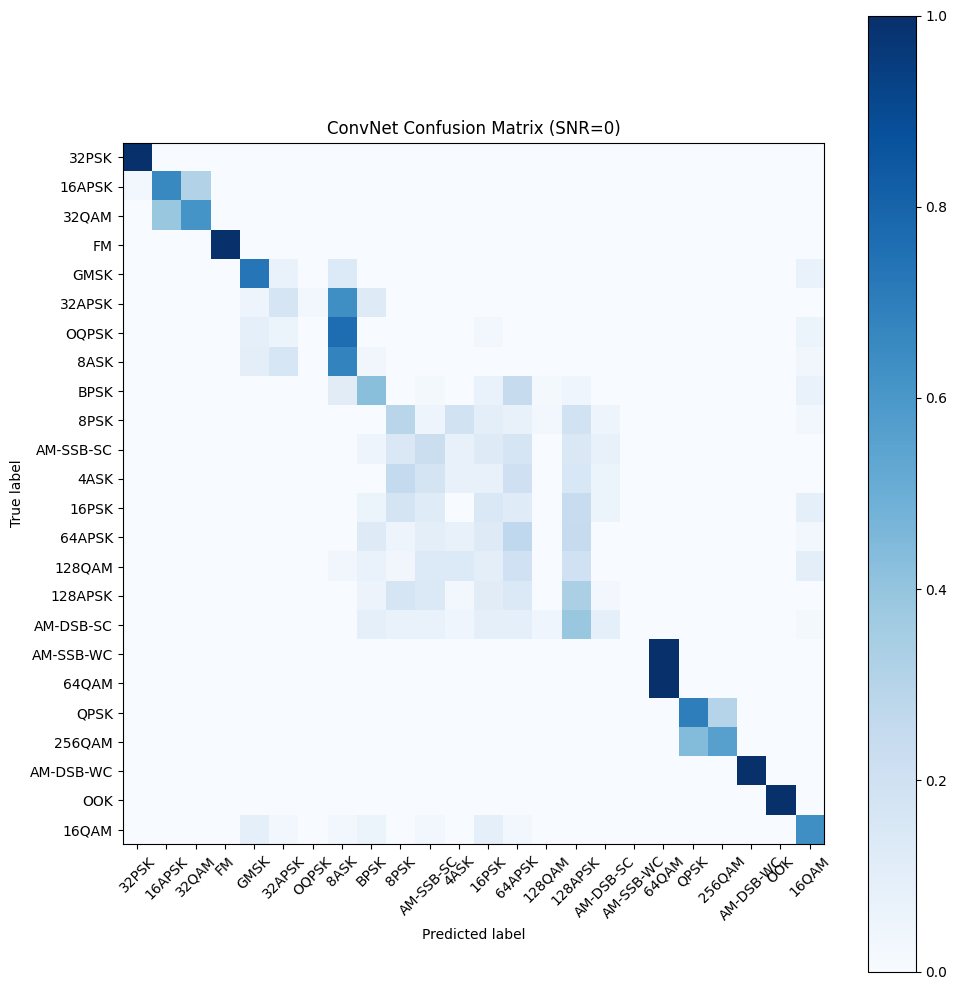

<Figure size 640x480 with 0 Axes>

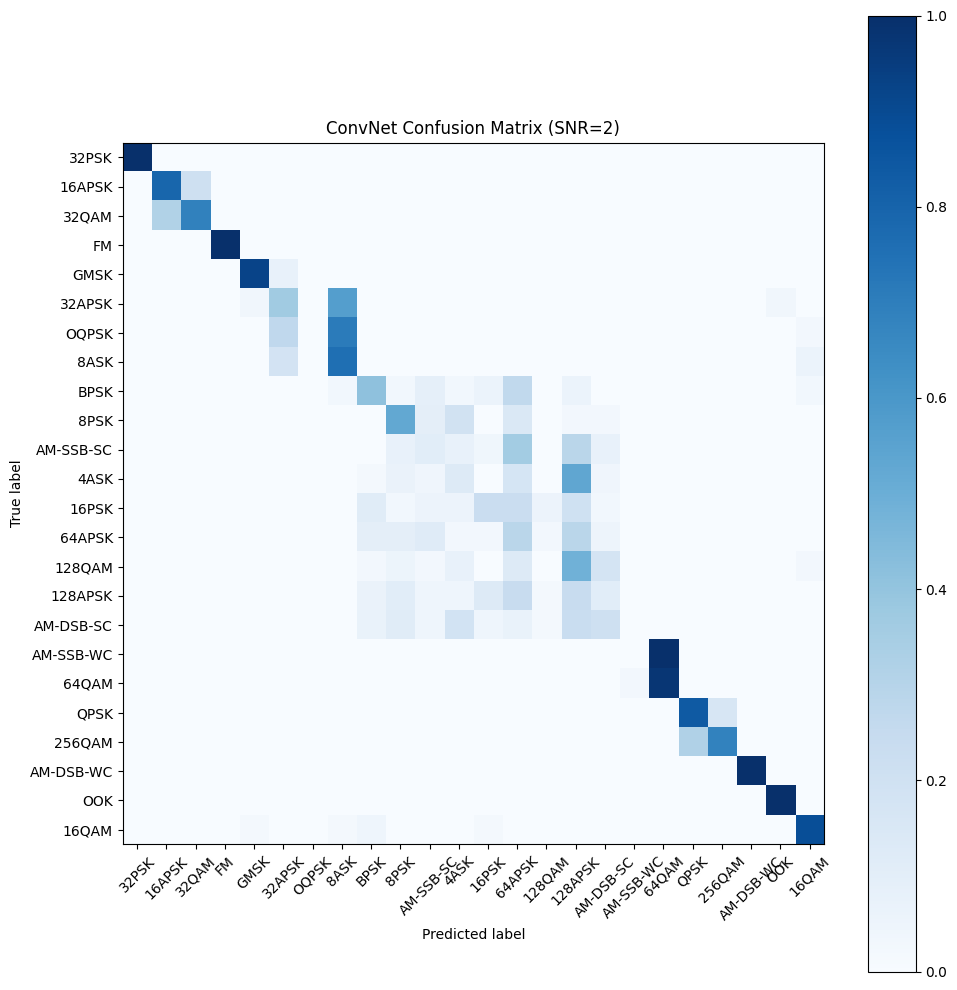

<Figure size 640x480 with 0 Axes>

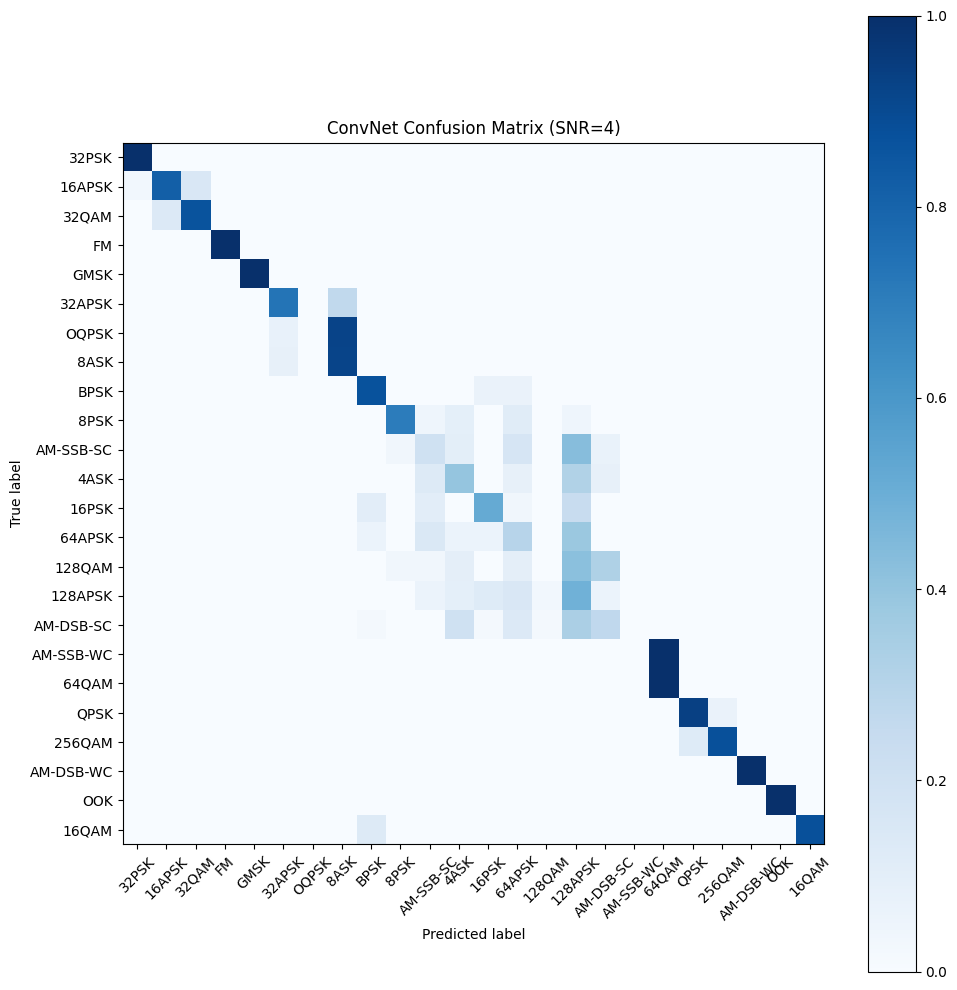

<Figure size 640x480 with 0 Axes>

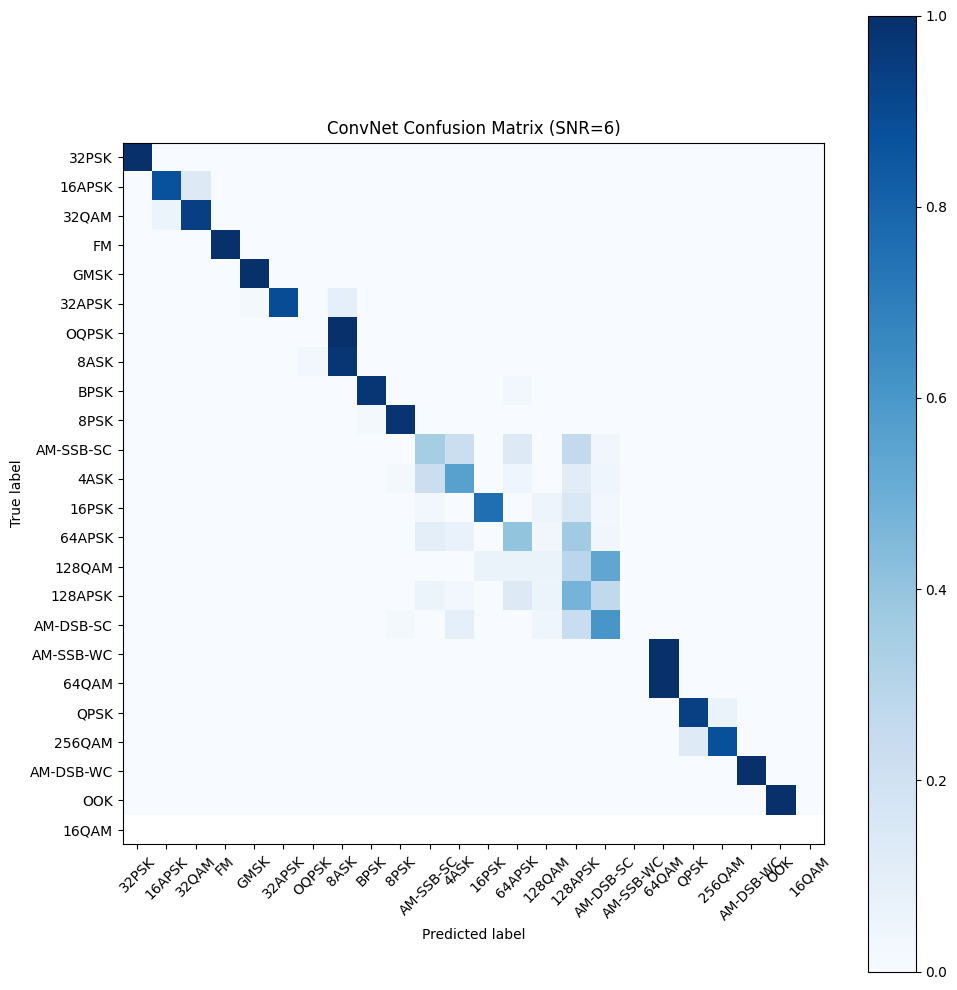

<Figure size 640x480 with 0 Axes>

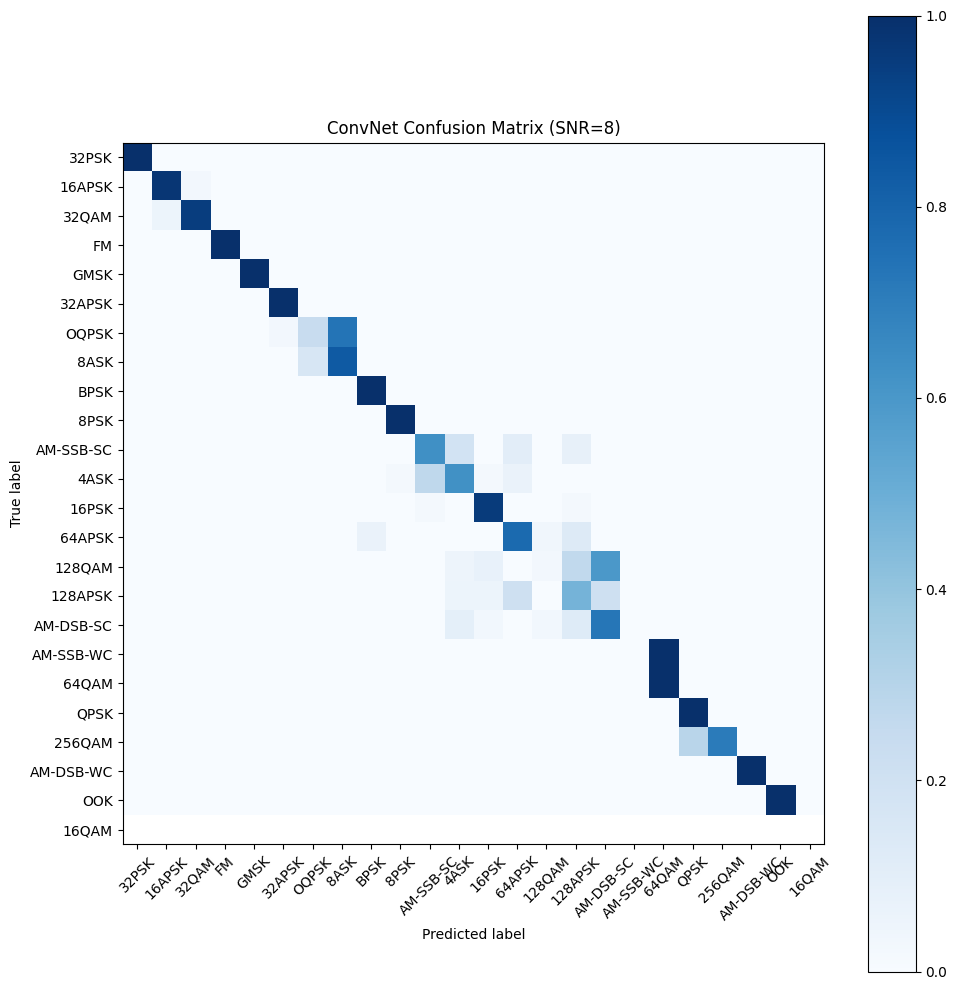

<Figure size 640x480 with 0 Axes>

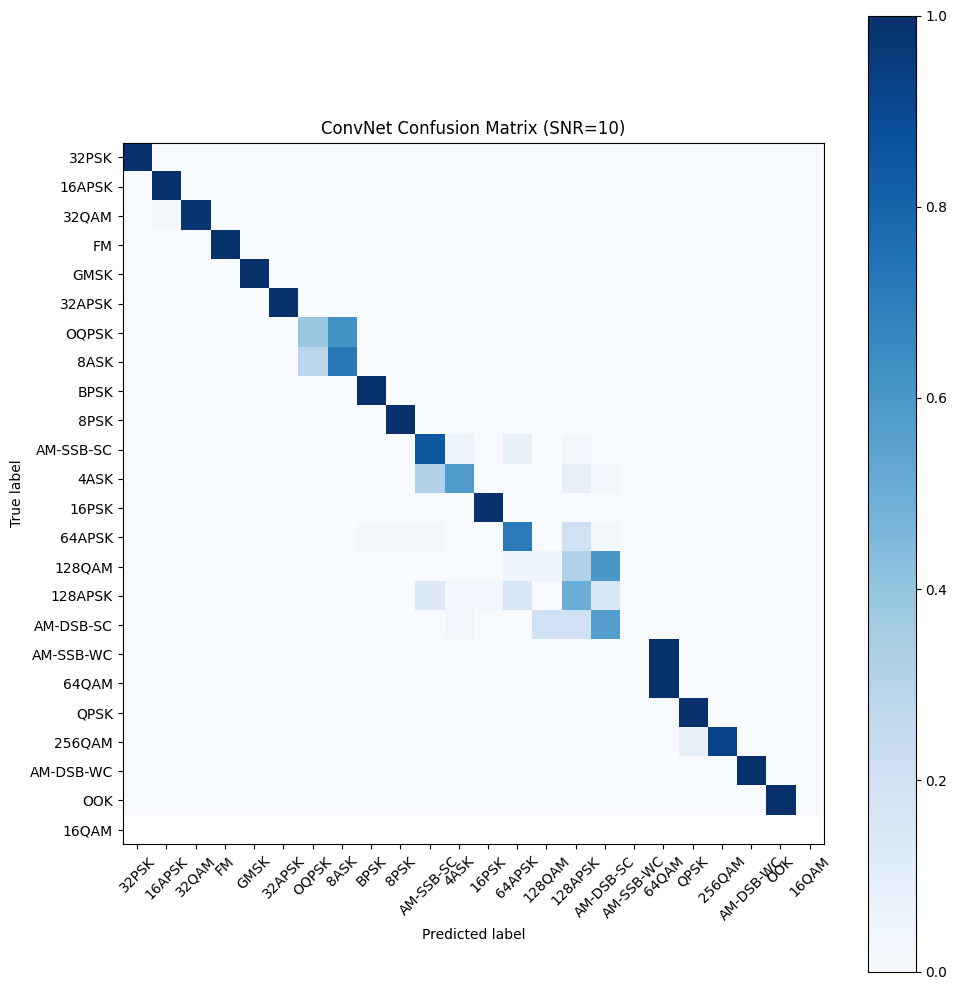

<Figure size 640x480 with 0 Axes>

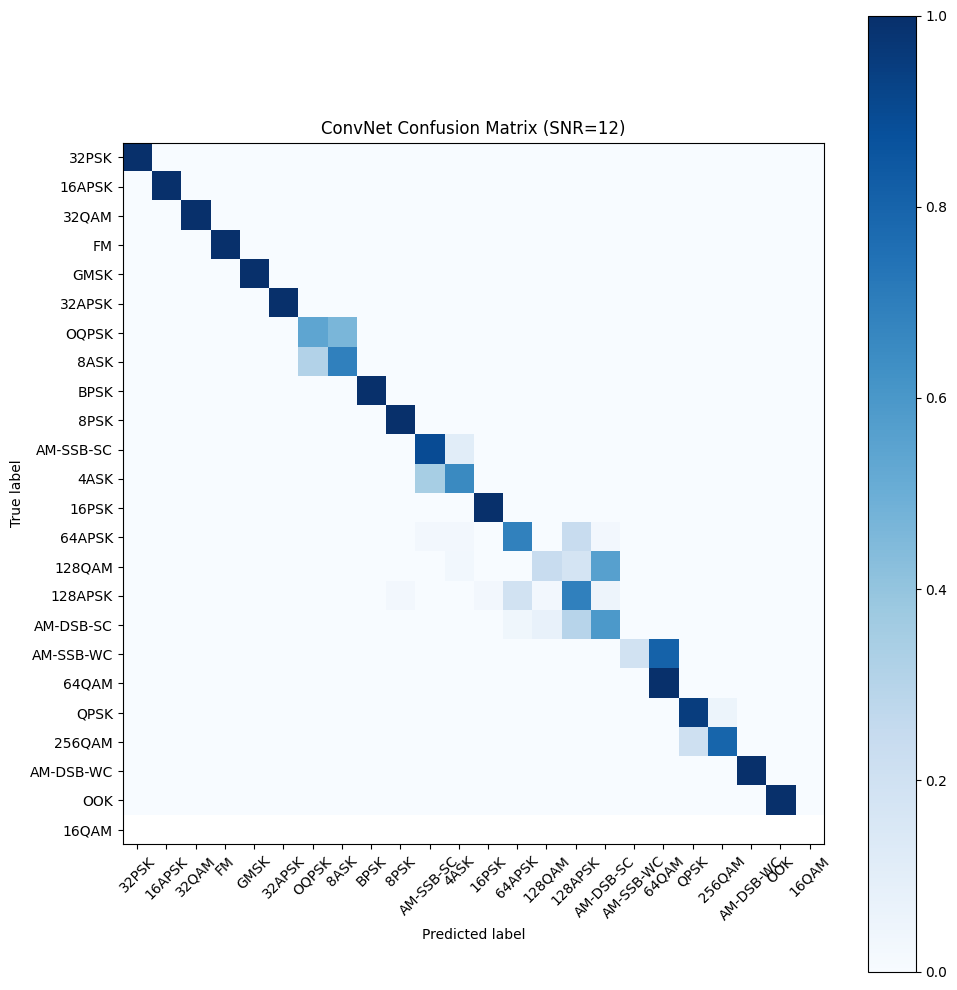

<Figure size 640x480 with 0 Axes>

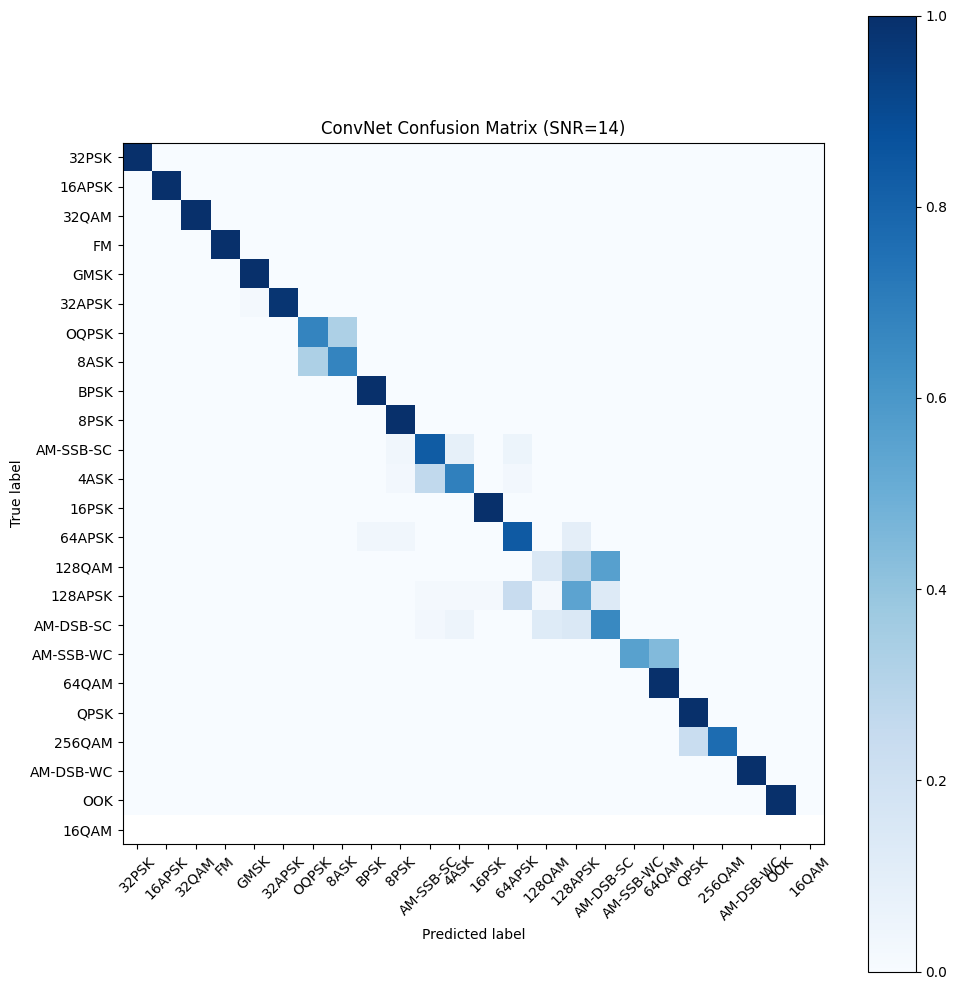

<Figure size 640x480 with 0 Axes>

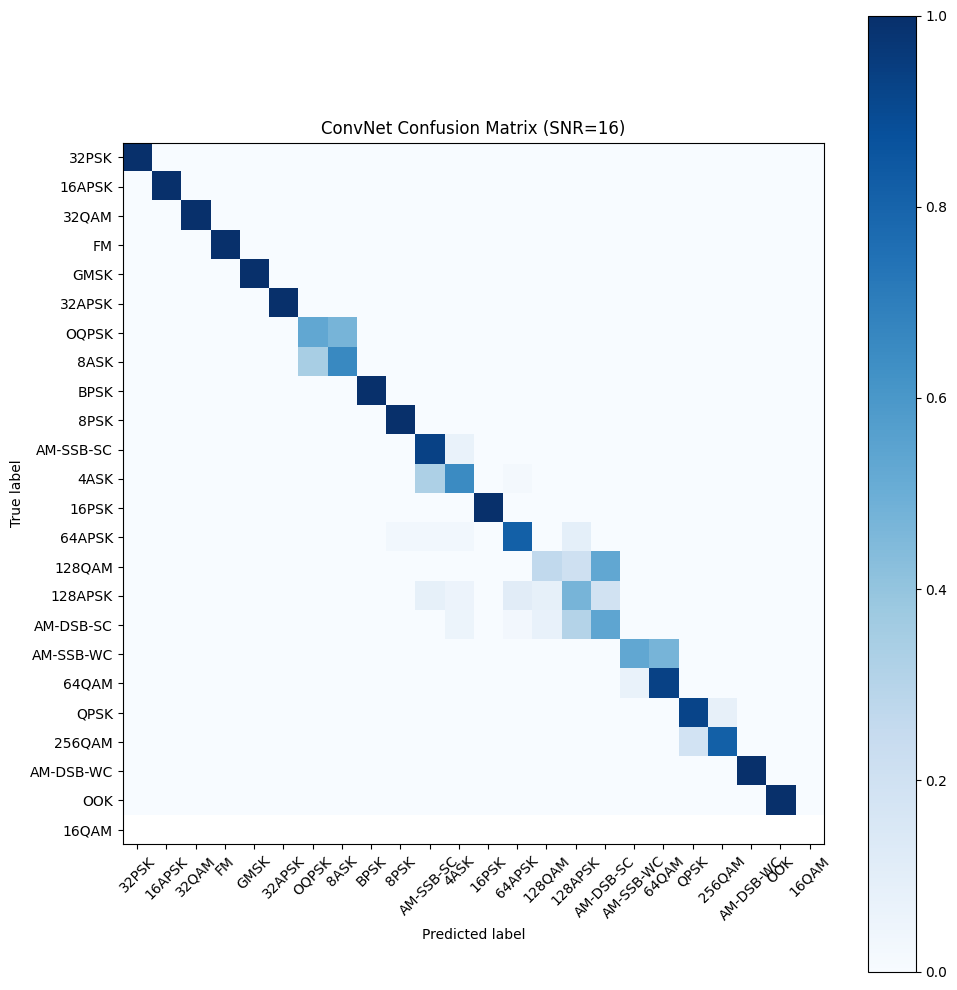

<Figure size 640x480 with 0 Axes>

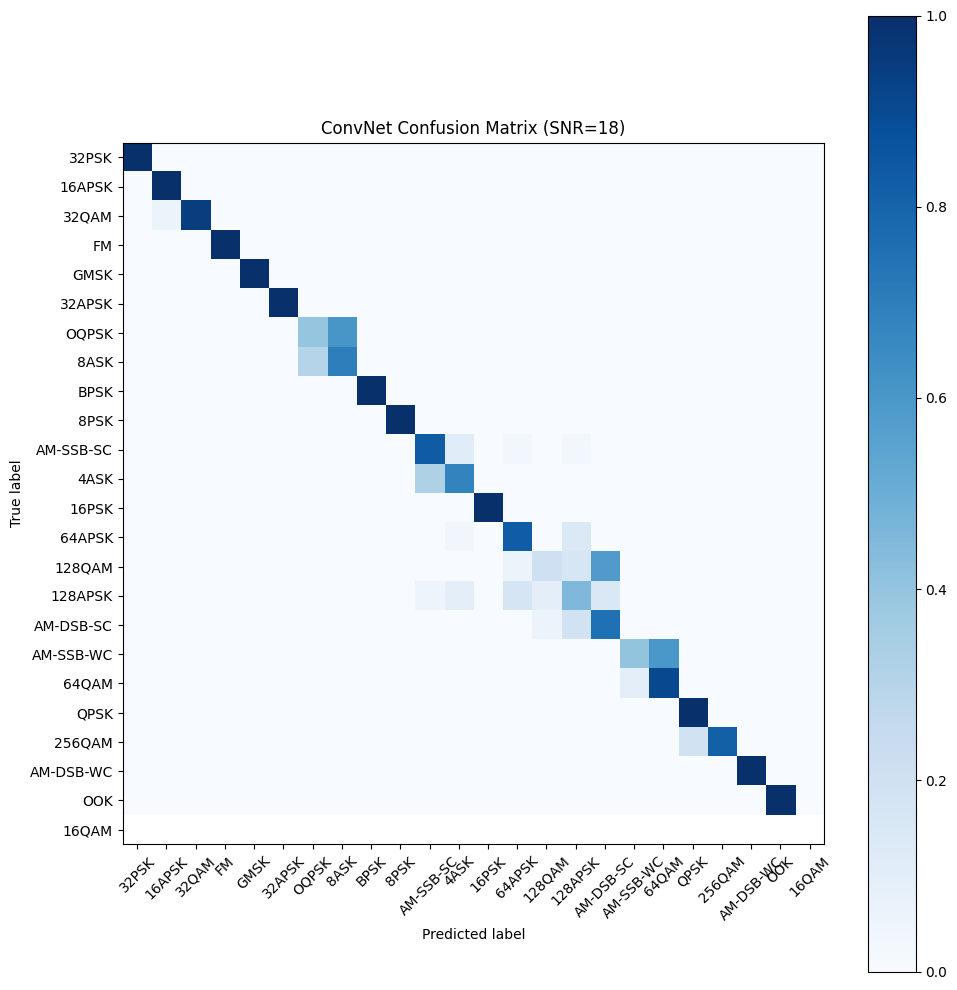

<Figure size 640x480 with 0 Axes>

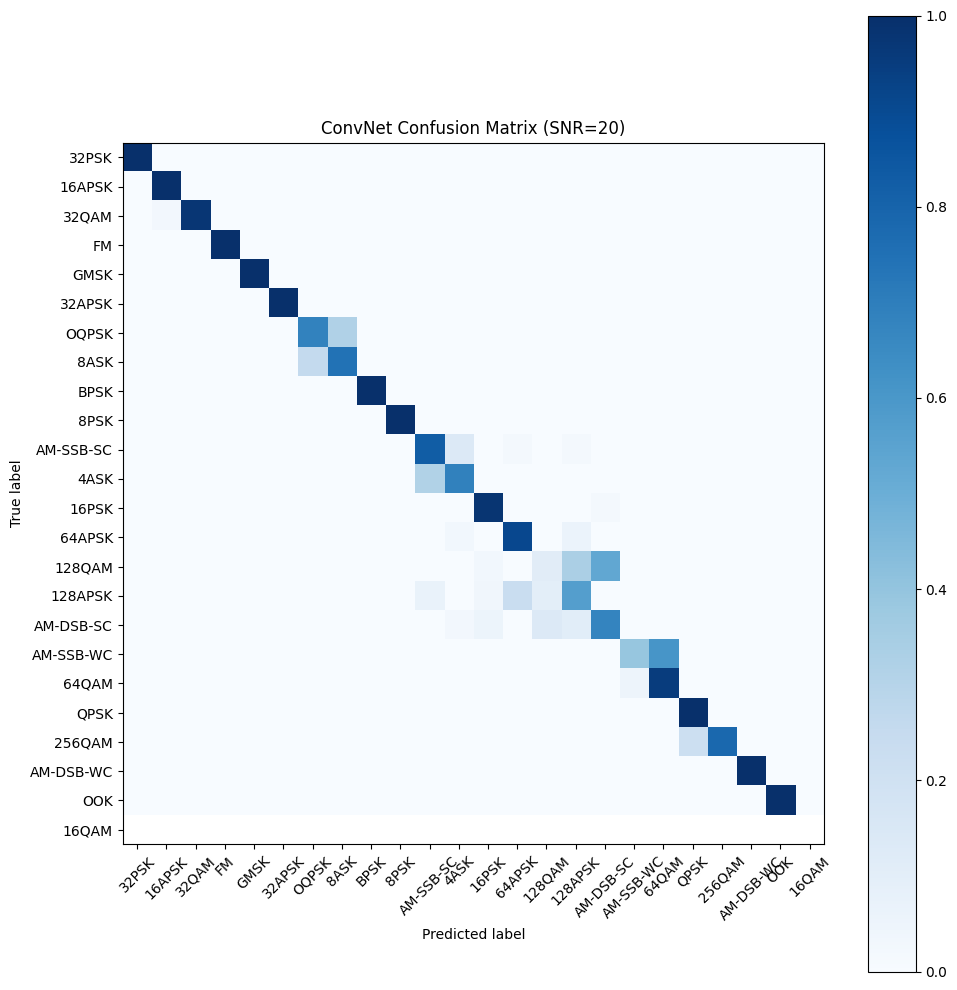

<Figure size 640x480 with 0 Axes>

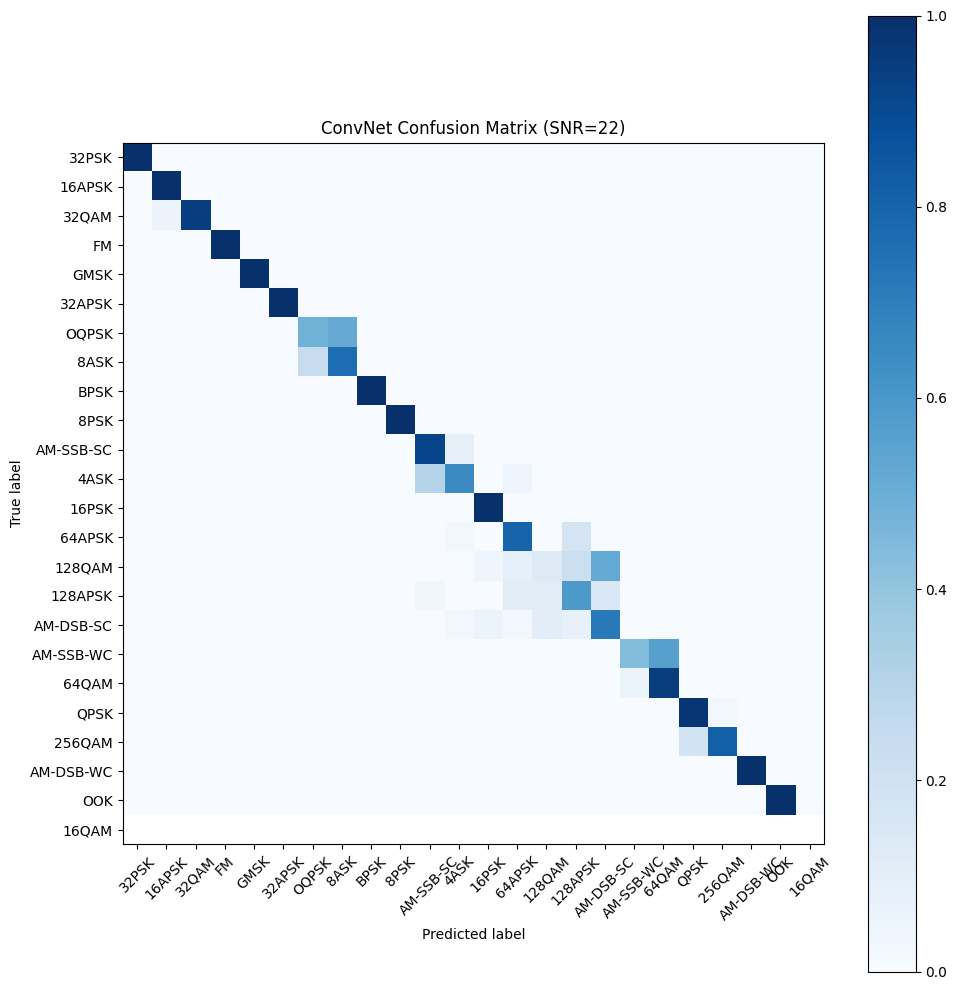

<Figure size 640x480 with 0 Axes>

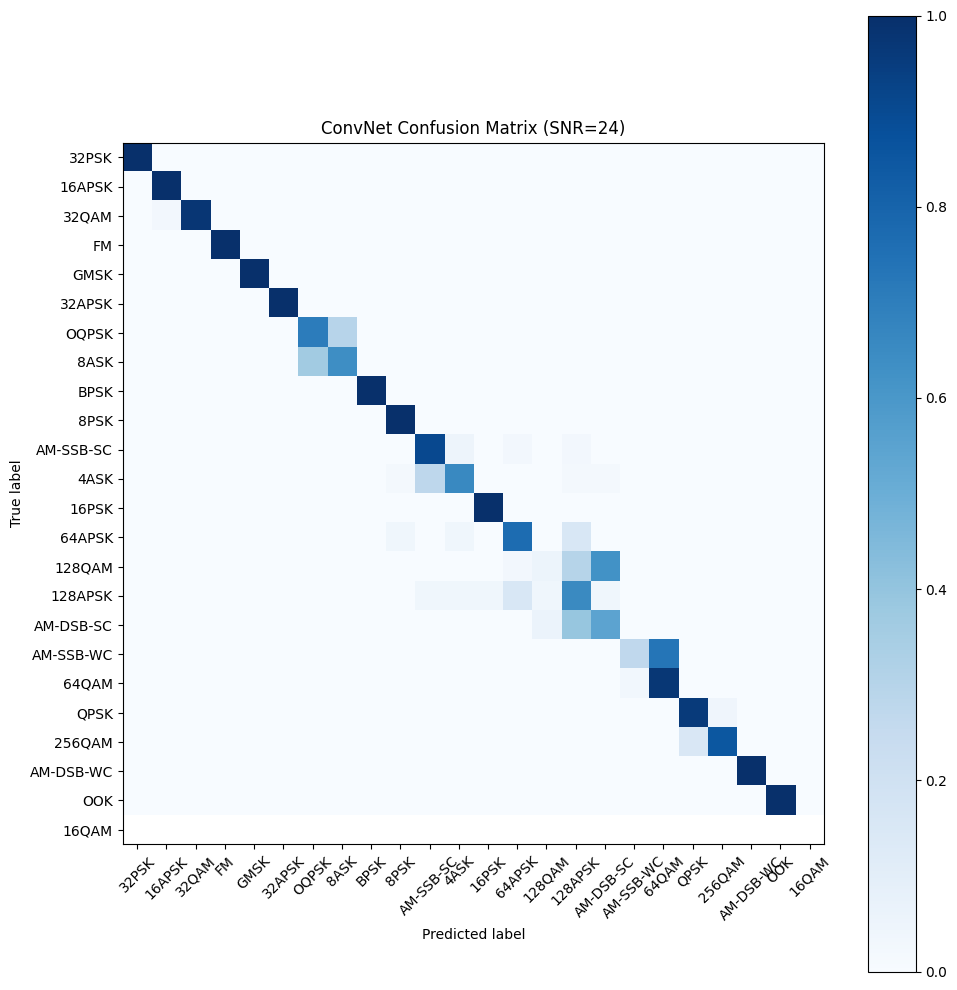

<Figure size 640x480 with 0 Axes>

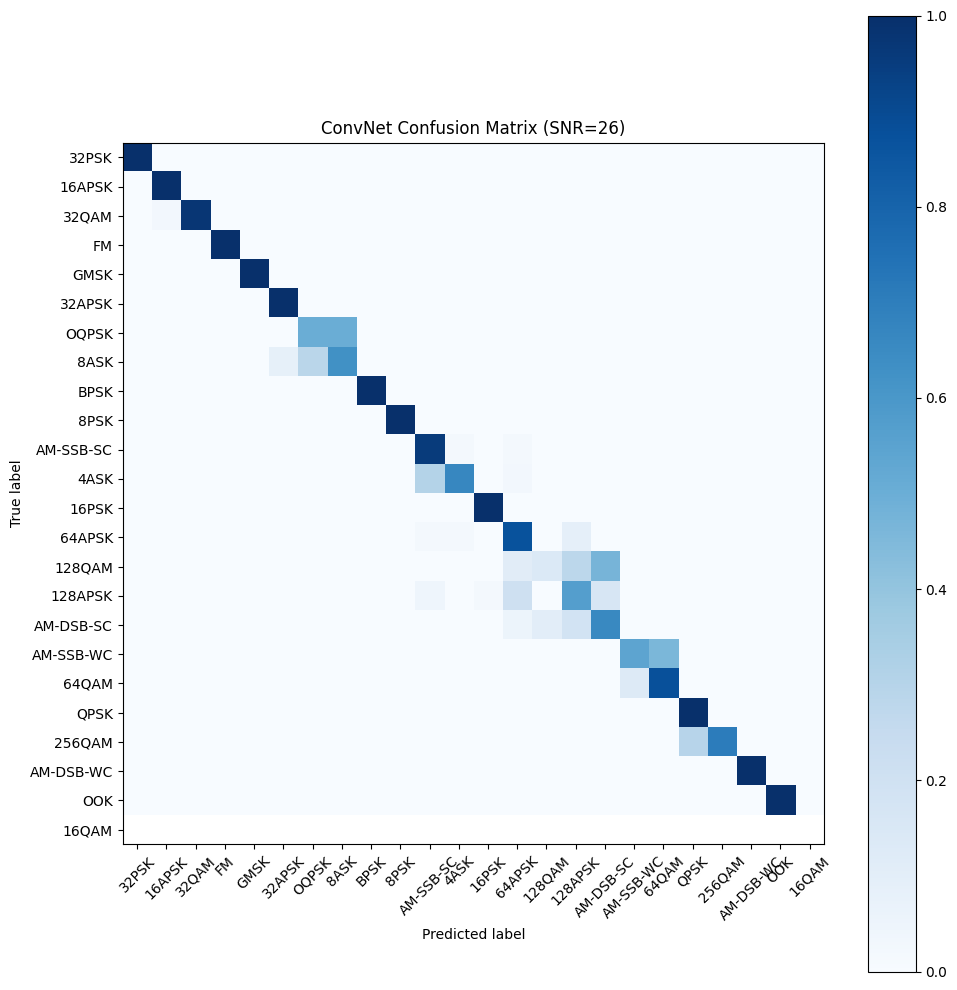

<Figure size 640x480 with 0 Axes>

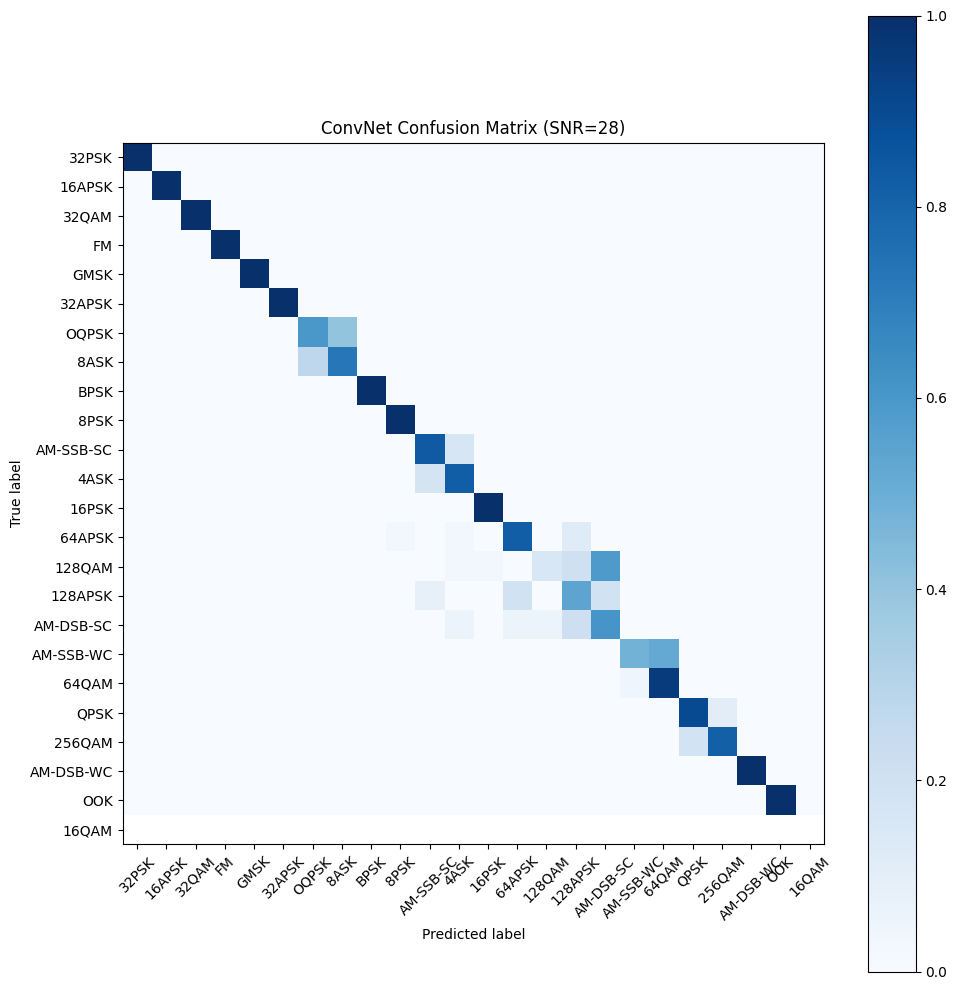

<Figure size 640x480 with 0 Axes>

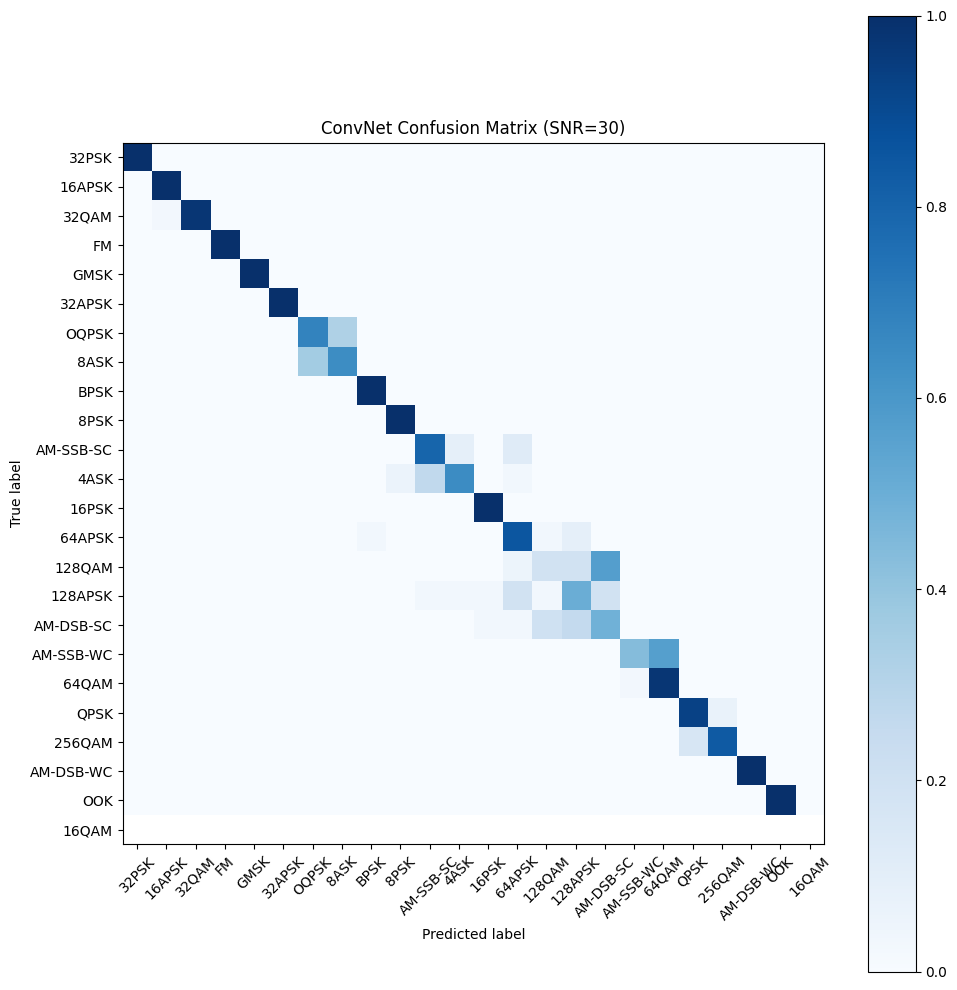

In [ ]:
#Predicting and generating the confusion matrix
batch_size = 1024
test_Y_hat = model.predict([X_test, X_test_features], batch_size=batch_size)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] += 1
for i in range(len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes)

# Printing accuracy per class
for i in range(len(confnorm)):
    print(classes[i], confnorm[i, i])

# Calculate accuracy across different SNR levels
acc = {}
Z_test = Z_combined[test_idx].reshape((len(Z_combined[test_idx])))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test == snr]
    Y_test_snr = Y_test[Z_test == snr]
    X_test_snr_features = X_test_features[Z_test == snr]

    pre_Y_test = model.predict([X_test_snr, X_test_snr_features])
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(X_test_snr.shape[0]):
        j = list(Y_test_snr[i, :]).index(1)
        k = int(np.argmax(pre_Y_test[i, :]))
        conf[j, k] += 1
    for i in range(len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy %s: " % snr, cor / (cor + ncor))
    acc[snr] = cor / (cor + ncor)

In [ ]:
# Smoothing the curve using interpolation
snrs = list(acc.keys())
accuracies = list(acc.values())
snr_new = np.linspace(min(snrs), max(snrs), 300)
accuracies_smooth = np.interp(snr_new, snrs, accuracies)

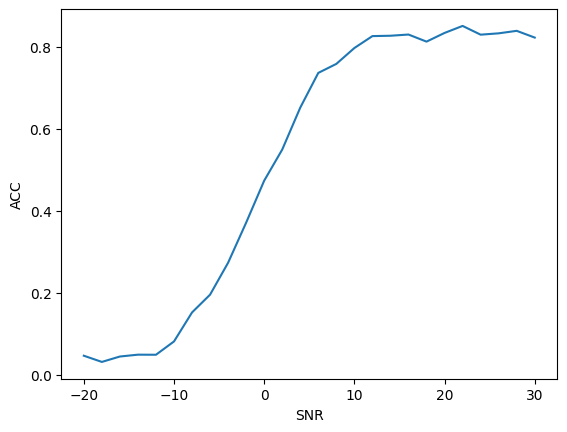

In [ ]:
# Plotting accuracy vs SNR
plt.plot(acc.keys(), acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()